In [64]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<style>
td {
  text-align: center;
}

th {
  text-align: center;
}
</style>

# 트랜스포머와 케라스를 활용한 기계 번역

이 튜토리얼은 [시퀀스-투-시퀀스](https://developers.google.com/machine-learning/glossary#sequence-to-sequence-task) [Transformer 혹은 트랜스포머](https://developers.google.com/machine-learning/glossary#Transformer) 모델을 생성하고 학습시켜 [포르투갈어를 영어로 번역](https://www.tensorflow.org/datasets/catalog/ted_hrlr_translate#ted_hrlr_translatept_to_en)하는 방법을 설명합니다. 트랜스포머는 Vaswani 등이 ["Attention is all you need"](https://arxiv.org/abs/1706.03762)에서 제안했습니다. (2017).

트랜스포머는 CNN 및 RNN을 [셀프 어텐션](https://developers.google.com/machine-learning/glossary#self-attention)으로 대체하는 심층 신경망입니다. 셀프 어텐션을 통해 트랜스포머는 입력 시퀀스 전체에 걸쳐 정보를 쉽게 전송할 수 있습니다.

[Google AI 블로그 게시물](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html) 설명:

> 기계 번역을 위한 신경망에는 일반적으로 입력 문장을 읽고 이를 표현하는 인코더가 포함됩니다. 그런 다음 디코더는 인코더에서 생성된 표현을 참조하면서 단어별로 출력 문장을 생성합니다. 트랜스포머는 각 단어에 대한 초기 표현 또는 임베딩을 생성하는 것으로 시작합니다. 그런 다음 셀프 어텐션을 사용하여 다른 모든 단어의 정보를 집계하고 전체 컨텍스트가 고려된 새로운 표현을 단어별로 생성합니다. 이는 아래 그림에서 채원진 원으로 표현되어 있습니다. 그런 다음 이 단계는 모든 단어에 대해 병렬로 여러 번 반복되어 연속적으로 새로운 표현을 생성합니다.

<img src="https://www.tensorflow.org/images/tutorials/transformer/apply_the_transformer_to_machine_translation.gif" alt="Applying the Transformer to machine translation">

그림 1: 기계 번역에 트랜스포머 적용하기. 소스: [Google AI Blog](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html).


소화해야 할 내용이 많기 때문에 이 튜토리얼의 목표는 이해하기 쉬운 부분으로 나누는 것입니다. 이 튜토리얼에서는 다음을 수행합니다.

- 데이터 준비
- 필요한 구성 요소 구현
  - 위치 임베딩
  - 어텐션 레이더
  - 인코더와 디코더
- 트랜스포머 구축 및 학습
- 번역 생성
- 모델 익스포트


어텐션 메커니즘에 대해 알고 있으면 이 튜토리얼을 최대한 이해하는 도움이 되지만 기본적인 내용은 여기에서도 다시 설명을 하도록 하겠습니다.

트랜스포머는 [어텐션을 추가한 NMT 튜토리얼](https://www.tensorflow.org/text/tutorials/nmt_with_attention)의 모델과 유사한 시퀀스-시퀀스 인코더-디코더 모델입니다.
단일 레이어 트랜스포머는 작성하는 데 약간 더 많은 코드가 필요하지만 해당 인코더-디코더 RNN 모델과 거의 동일합니다. 유일한 차이점은 RNN 레이어가 셀프 어텐션 레이어로 대체된다는 것입니다.
이 튜토리얼에서는 더 크고 강력하지만 근본적으로 더 복잡하지는 않은 4층 트랜스포머를 구축합니다.

<table>
<tr>
  <th>The <a href=https://www.tensorflow.org/text/tutorials/nmt_with_attention>RNN+어텐션 모델</a></th>
  <th>단일 계층 트랜스포머</th>
</tr>
<tr>
  <td>
   <img width=411 src="https://www.tensorflow.org/images/tutorials/transformer/RNN+attention-words.png"/>
  </td>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"/>
  </td>
</tr>
</table>

이 노트북에서 모델을 훈련한 후에는 포르투갈어 문장을 입력하고 이를 영어로 번역할 수 있습니다.<br>

<img src="https://www.tensorflow.org/images/tutorials/transformer/attention_map_portuguese.png" alt="어텐션 히트맵">

그림 2: 이 튜토리얼이 끝나면 생성할 수 있는 시각화된 어텐션 가중치

## 트랜스포머가 중요한 이유

- 트랜스포머는 자연어와 같은 순차 데이터를 모델링하는데 탁월합니다.
- [반복 신경망 (RNN)](./text_generation.ipynb)과 달리 트랜스포머는 병렬화가 가능합니다. 이를 통해 GPU 및 TPU와 같은 하드웨어에서 효율성을 높일 수 있습니다. 주된 이유는 트랜스포머가 반복을 어텐션으로 대체하고 계산이 동시에 수행될 수 있다는 점입니다. 레이어 출력은 RNN과 같은 시리즈 대신 병렬로 계산될 수 있습니다.
- [RNN](https://www.tensorflow.org/guide/keras/rnn)(예: [seq2seq, 2014](https://arxiv.org/abs/1409.3215)) 또는 [컨볼루션 신경망 (CNN)](https://www.tensorflow.org/tutorials/images/cnn)과 달리 (예: [ByteNet](https://arxiv.org/abs/1610.10099)), 트랜스포머는 입력 또는 출력 시퀀스 데이터에 존재하는 원거리 또는 넓은 범위의 컨텍스트와 종석성을 캡처할 수 있습니다. 따라서 더 긴 연결을 학습할 수 있습니다. 어텐션을 사용하면 각 시퀀스내 위치한 단어가 각 계층에서 전체 입력에 액세스할 수 있는 반면, RNN 및 CNN에서는 정보가 장거리 이동을 위해 많은 처리 단계를 거쳐야 하므로 학습이 더 어렵습니다.
- 트랜스포머는 데이터 전체의 시간적/공간적 관계에 대해 어떠한 가정도 하지 않습니다. 이는 개체 집합(예: [스타크래프트 유닛](https://www.deepmind.com/blog/alphastar-mastering-the-real-time-strategy-game-starcraft-ii))을 처리하는 데 이상적입니다.

<img src="https://www.tensorflow.org/images/tutorials/transformer/encoder_self_attention_distribution.png" width="800" alt="Encoder self-attention distribution for the word it from the 5th to the 6th layer of a Transformer trained on English-to-French translation">

그림 3: 영어-프랑스어 번역에 대해 훈련된 트랜스포머의 5번째 레이어와 6번째 레이어 사이에서 단어 "it"에 대한 인코더 셀프 어텐션 분포. 출처: [Google AI 블로그](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html).


## 셋업

데이터세트를 로드하기 위해 [TensorFlow 데이터셋](https://tensorflow.org/datasets), 그리고 텍스트 처리를 위해 [TensorFlow 텍스트](https://www.tensorflow.org/text)를 설치합니다:

In [117]:
!echo $HOME
!python --version

# 아래 명령이 SageMaker의 ml.g4dn.16xlarge 노트북 인스턴스에서 GPU 갯수가 0으로 표시되는 문제는 추가 확인 필요s
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

/Users/sanghyou
Python 3.11.6
Num GPUs Available:  0


In [119]:
# GPU 상태 추가 확인
%pip install torch
import torch

print(f'\nAvailable cuda = {torch.cuda.is_available()}')
print(f'\nGPUs availables = {torch.cuda.device_count()}')
print(f'\nCurrent device = {torch.cuda.current_device()}')
print(f'\nCurrent Device location = {torch.cuda.device(0)}')
print(f'\nName of the device = {torch.cuda.get_device_name(0)}')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 13.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 8.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.7/146.7 MB 15.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.8 MB/s eta 0:00:0000:0100:01m
Note: you may need to restart the kernel to use updated packages.

Available cuda = False

GPUs availables = 0


AssertionError: Torch not compiled with CUDA enabled

In [65]:
# Install the most re version of TensorFlow to use the improved
# masking support for `tf.keras.layers.MultiHeadAttention`.
#!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
#!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
!pip install protobuf~=3.20.3
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text tensorflow
!pip install -q matplotlib
!pip install -q ipywidgets

# 아래 tf.keras.utils.plot_model() 명령이 수행되기 위해서는 미리 pydot, graphviz를 설치해야 합니다.
# 필요하면 Jupyter 커널을 재시작합니다.
# %pip install pydot graphviz

필요한 모듈 임포트:

In [66]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text

## 데이터 처리

이 섹션에서는 [서브워드 토크나이저 튜토리얼](https://www.tensorflow.org/text/guide/subwords_tokenizer)에서 데이터세트와 하위 단어 토크나이저를 다운로드한 다음 학습을 위해 `tf.data.Dataset`에 모두 래핑합니다.

 <section class="expandable tfo-display-only-on-site">
 <button type="button" class="button-red button expand-control">Toggle section</button>

### 데이터셋 다운로드

TensorFlow 데이터세트를 사용하여 [포르투갈어-영어 번역 데이터세트](https://www.tensorflow.org/datasets/catalog/ted_hrlr_translate#ted_hrlr_translatept_to_en) ```Talks Open Translation Project```를 로드합니다. 이 데이터 세트에는 약 52,000개의 학습, 1,200개의 검증 및 1,800개의 테스트 예제가 포함되어 있습니다.

In [67]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en',
                               with_info=True,
                               as_supervised=True)
print(examples)
train_examples, val_examples = examples['train'], examples['validation']

{'train': <_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>, 'validation': <_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>, 'test': <_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>}


TensorFlow 데이터세트에서 반환된 `tf.data.Dataset` 객체는 텍스트 예제 쌍을 생성합니다.

In [68]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
  print('> Examples in Portuguese:')
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))
  print()

  print('> Examples in English:')
  for en in en_examples.numpy():
    print(en.decode('utf-8'))

> Examples in Portuguese:
e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

> Examples in English:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


2023-12-13 17:43:11.861919: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### 토크나이저 준비

이제 데이터세트를 로드하였으므로 각 요소가 [토큰](https://developers.google.com/machine-learning/glossary#token) 또는 토큰 ID (숫자로 표현)로 표시되도록 텍스트를 토큰화해야 합니다.

토큰화는 텍스트를 "토큰"으로 나누는 프로세스입니다. 토크나이저에 따라 이러한 토큰은 문장 조각, 단어, 하위 단어 또는 문자를 나타낼 수 있습니다. 토큰화에 대해 자세히 알아보려면 [토크나이저 가이드](https://www.tensorflow.org/text/guide/tokenizers)를 참고해 보세요.

이 튜토리얼에서는 [서브워드 토크나이저](https://www.tensorflow.org/text/guide/subwords_tokenizer) 튜토리얼에 내장된 토크나이저를 사용합니다. 해당 튜토리얼은 **데이터세트**에 대해 두 개의 `text.BertTokenizer` 객체(영어용 하나, 포르투갈어용 하나)를 최적화하고 이를 TensorFlow `saved_model` 형식으로 내보냅니다.

> 참고: 이는 [원본 논문](https://arxiv.org/pdf/1706.03762.pdf) 섹션 5.1과 다릅니다. 섹션 5.1에서는 어휘가 포함된 소스와 대상 모두에 대해 어휘 사전의 크기가 37,000인 단일 바이트 쌍 토크나이저를 사용했습니다.

`saved_model`을 다운로드하고 추출하고 가져옵니다.

In [69]:
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)

'./ted_hrlr_translate_pt_en_converter.zip'

In [70]:
tokenizers = tf.saved_model.load(model_name)

`tf.saved_model`에는 두 개의 텍스트 토크나이저가 포함되어 있습니다. 하나는 영어용이고 다른 하나는 포르투갈어용입니다. 둘 다 동일한 방법을 사용합니다:

In [71]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

`tokenize` 메서드는 문자열 배치(묶음)를 패딩된 토큰 ID 배치로 변환합니다. 이 메서드 토큰화를 수행하기 이전에 입력을 구두점, 소문자로 나누고 유니코드 정규화합니다. 입력 데이터가 이미 표준화되어 있으므로 해당 표준화는 여기에 표시되지 않습니다.

In [72]:
print('> This is a batch of strings:')
for en in en_examples.numpy():
  print(en.decode('utf-8'))

> This is a batch of strings:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


In [73]:
encoded = tokenizers.en.tokenize(en_examples)

print('> This is a padded-batch of token IDs:')
for row in encoded.to_list():
  print(row)

> This is a padded-batch of token IDs:
[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]


TensorFlow에서 패딩된 토큰 ID 배치는 다양한 길이의 시퀀스를 동시에 처리해야 하는 자연어 처리 작업에 일반적으로 사용됩니다. 패딩된 토큰 ID 배치를 생성할 때 숫자 2와 3은 일반적으로 토큰화 프로세스 내의 특수 토큰을 나타냅니다.

많은 토큰화 체계에서 숫자 2는 시퀀스의 시작 또는 시퀀스 시작 토큰(BERT와 같은 모델에서는 [CLS]로 표시되는 경우가 많음)을 나타내는 데 자주 사용되는 반면, 숫자 3은 시퀀스의 끝을 나타내는 데 사용됩니다. 시퀀스 또는 시퀀스 끝 토큰(BERT와 같은 모델에서는 종종 [SEP]로 표시됨).

이러한 특수 토큰은 모델이 주어진 시퀀스 내에서 텍스트의 다양한 세그먼트 간의 경계와 관계를 이해하는 데 도움이 됩니다. 이는 텍스트 분류, 명명된 엔터티 인식 및 질문 응답과 같은 다양한 NLP 작업에 필수적입니다.

`detokenize` 메소드는 이러한 토큰 ID를 사람이 읽을 수 있는 텍스트로 다시 변환해 줍니다:

In [74]:
round_trip = tokenizers.en.detokenize(encoded)

print('> This is human-readable text:')
for line in round_trip.numpy():
  print(line.decode('utf-8'))

> This is human-readable text:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .


저수준 `lookup` 메서드는 토큰 ID를 토큰 텍스트로 변환합니다:

In [75]:
print('> This is the text split into tokens:')
tokens = tokenizers.en.lookup(encoded)
tokens

> This is the text split into tokens:


<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability',
  b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage',
  b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip',
  b'##ity', b'.', b'[END]']                                                 ,
 [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?',
  b'[END]']                                                           ,
 [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for',
  b'curiosity', b'.', b'[END]']                                          ]>

출력은 서브 워드 코튼화의 "Subword"를 보여줍니다.

예를 들어, `'searchability'`라는 단어는 `'search'`와 `'##ability'`로 분해되고, `'serendipity'`라는 단어는 `'s'`, `'##ere'`, `'##nd'`, `'##ip'` 및 `'##ity'`로 분해됩니다.

토큰화된 텍스트에는 `'[START]'` 및 `'[END]'` 토큰이 포함되어 있습니다.

> (참고)<br>
> 하위 단어 토큰화는 자연어 처리(NLP)에서 단어를 하위 단어 단위로 분할하는 데 사용되는 텍스트 토큰화 기술입니다. 이 접근 방식은 복잡한 형태와 어원이 있는 언어를 처리하는 것뿐만 아니라 기계 학습 모델에서 어휘 범위를 벗어난 단어를 처리하는 데 특히 유용할 수 있습니다.<br>
BPE(바이트 쌍 인코딩) 및 WordPiece와 같은 하위 단어 토큰화 알고리즘은 훈련 코퍼스에서 가장 빈번한 문자 또는 하위 단어 단위 쌍을 반복적으로 병합하여 하위 단어 단위의 어휘를 생성하는 방식으로 작동합니다. 새로운 텍스트를 토큰화할 때 단어는 학습된 어휘를 기반으로 하위 단어 단위로 분할되어 희귀하거나 보이지 않는 단어를 더 효과적으로 처리하고 언어 형태를 더 효율적으로 표현할 수 있습니다.<br>
이 방법은 기계 번역, 개체명 인식, 감정 분석 등 NLP 작업에 널리 사용되며 NLP 모델의 견고성과 일반화를 향상시키는 데 효과적인 것으로 입증되었습니다.

데이터세트의 토큰 분포는 다음과 같습니다. 일단 포르투갈어와 영어 학습 데이터를 토큰화하여 적재합니다.

In [76]:
lengths = []

for pt_examples, en_examples in train_examples.batch(1024):
  pt_tokens = tokenizers.pt.tokenize(pt_examples)
  lengths.append(pt_tokens.row_lengths())
  
  en_tokens = tokenizers.en.tokenize(en_examples)
  lengths.append(en_tokens.row_lengths())
  print('.', end='', flush=True)

...................................................

103570
[25 10 12 ... 49 16 18]


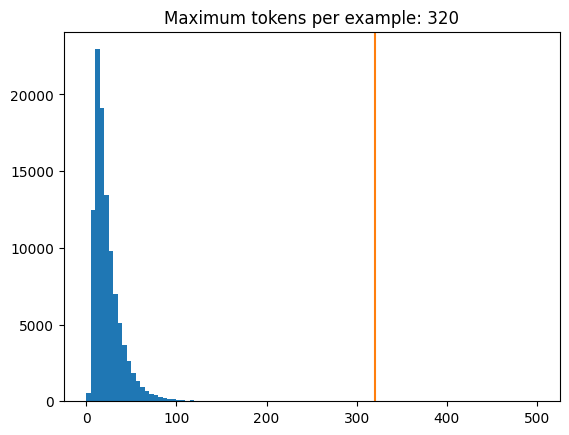

In [77]:
all_lengths = np.concatenate(lengths)
print(len(all_lengths))
print(all_lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}');

위 코드는 matplotlib 라이브러리를 사용하여 토큰의 길이 분포를 시작적으로 표시해 줍니다.

1. `plt.hist(all_lengths, np.linspace(0, 500, 101))`: 
   - 이 줄은 matplotlib의 `plt.hist()`를 사용하여 히스토그램을 생성합니다. 이는 0에서 500 사이에 균일한 간격으로 배치된 101개의 빈을 사용하여 'all_lengths' 배열의 값 분포를 표시하도록 설계되었습니다. 즉, 히스토그램을 그리기 위해 0에서 500까지의 범위를 101개의 동일한 간격으로 나눕니다.
2. `plt.ylim(plt.ylim())`: 
   - 이 코드는 그래프의 y축 최대 경계를 적재될 데이터의 최대값으로 설정합니다.
3. `max_length = max(all_lengths)`: 
   - `all_lengths` 배열의 최대값을 계산하고 `max_length` 변수에 할당합니다.
4. `plt.plot([max_length, max_length], plt.ylim())`: 
   - x 좌표 `max_length`를 플롯에 수직선으로 추가합니다. y축의 경계는 그대로 둡니다. 
5. `plt.title(f'Maximum tokens per example: {max_length}')`: 
   - `max_length` 값으로 표시되는 최대 토큰 길이를 그래프 타이틀로 설정합니다.

### `tf.data`를 사용하여 데이터 파이프라인 설정

다음 함수는 텍스트 배치를 입력으로 받아 훈련에 적합한 형식으로 변환합니다.

1. 입력 텍스트를 비정형 배치로 토큰화합니다.
2. `MAX_TOKENS`보다 길지 않도록 각각을 자릅니다.
3. 대상 (영어) 토큰을 입력과 레이블로 분할합니다. 이는 각 입력 위치에서 `label`이 다음 토큰의 ID가 되도록 한 단계씩 이동됩니다.
    즉, `en_inputs`가 `[START] | blue | sky`라면 `en_labels`는 `blue | sky | [END]`가 됩니다.
4. `RaggedTensor`를 패딩된 Dense `Tensor`로 변환합니다.
5. `(inputs, labels)` 쌍을 반환합니다.

Ragged Tensor<br>
[[1, 2, 3],
 [4, 5],
 [6, 7, 8, 9]]<br>

Dense Tensor<br>
[1, 2, 3]
 [4, 5, 6]
 [7, 8, 9]

In [78]:
MAX_TOKENS=128
def prepare_batch(pt, en):
    pt = tokenizers.pt.tokenize(pt)      # Output is ragged.
    pt = pt[:, :MAX_TOKENS]    # Trim to MAX_TOKENS.
    pt = pt.to_tensor()  # Convert to 0-padded dense Tensor

    en = tokenizers.en.tokenize(en)
    # print(en.shape)
    en = en[:, :(MAX_TOKENS+1)]
    # print(en.shape)
    en_inputs = en[:, :-1].to_tensor()  # Drop the [END] tokens
    en_labels = en[:, 1:].to_tensor()   # Drop the [START] tokens

    return (pt, en_inputs), en_labels

아래 함수는 텍스트 예제 데이터 세트를 학습용 배치 데이터로 변환합니다.

1. 텍스트를 토큰화하고 너무 긴 시퀀스를 필터링합니다.
   (토큰나이저는 대규모 배치에서 훨씬 더 효율적이기 때문에 `batch`/`unbatch`가 포함되었습니다.)
2. `cache` 메소드는 해당 작업이 한 번만 실행되도록 보장합니다.
3. 그런 다음 `shuffle` 및 `dense_to_ragged_batch`를 통해 순서를 무작위로 지정하고 예제 배치를 구성합니다.
4. 마지막으로 `prefetch`는 모델과 병렬로 데이터세트를 실행하여 필요할 때 데이터를 사용할 수 있도록 합니다. 자세한 내용은 [`tf.data`를 사용하여 성능 향상 도모하기](https://www.tensorflow.org/guide/data_performance.ipynb)를 참조하세요.

좀 더 큰 맥락에서 설명하면 다음과 같습니다.<br>

데이터세트 `ds`를 입력으로 받는 make_batches라는 함수를 정의합니다. 이 함수는 특정 순서로 데이터세트에 적용된 일련의 변환을 반환합니다.

1. 데이터 세트는 상수 `BUFFER_SIZE`로 지정된 버퍼 크기를 사용하여 섞입니다.
2. 그런 다음 섞인 데이터세트는 지정된 크기 `BATCH_SIZE`의 배치로 나뉩니다.
3. `prepare_batch` 함수는 `map` 함수를 사용하여 각 배치에 적용됩니다.
4. 그런 다음 성능 향상을 위해 버퍼 크기를 `tf.data.AUTOTUNE`으로 설정하여 데이터세트를 미리 가져옵니다.

In [79]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [80]:
def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

## 데이터셋 테스트 

In [81]:
# Create training and validation set batches.
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

결과로서 얻어지는 `tf.data.Dataset` 객체는 Keras를 사용한 학습을 위해 설정됩니다.
Keras의 `Model.fit` 함수는 `(inputs, labels)` 쌍이 학습 데이터로서 입력되는 것을 기대 합니다.
`inputs`은 토큰화된 포르투갈어 및 영어 시퀀스 쌍 `(pt, en)`입니다.
'레이블'은 1만큼 왼쪽으로 이동된 동일한 영어 시퀀스입니다.
이렇게 쉬프트시킴으로써 각 위치에서의 `label` 토큰은 `en` 입력 시퀀스의 다음 토큰이 되도록 할 수 있습니다.

<table>
<tr>
  <th>아래쪽에는 입력이 위쪽에는 레이블이 표시되어 있습니다.</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"/>
  </td>
</tr>
</table>

이는 모델이 조건적으로 활성화되는 "문맥 (Context; 여기서는 포르투갈어 시퀀스)"을 추가적으로 입력하였다는 점을 제외하면 텍스트 생성 모델과 동일합니다. 

이 설정을 "강제 티칭"이라고 합니다. 각 단계의 모델 출력에 관계없이 다음 단계의 입력으로 실제 값을 가져오기 때문입니다.
이는 텍스트 생성 모델을 교육하는 간단하고 효율적인 방법입니다.
모델을 순차적으로 실행할 필요가 없고, 서로 다른 시퀀스 위치의 출력을 병렬로 계산할 수 있으므로 효율적입니다.

또한 `입력, 출력` 쌍이 단순히 `포르투갈어, 영어` 시퀀스일 것으로 예상할 수 있습니다.
포르투갈어 시퀀스가 주어지면 모델은 영어 시퀀스를 생성하려고 시도합니다.

한편 추론 루프를 작성하고 모델의 출력을 입력으로 다시 전달함으로써 모델을 훈련시키는 것도 가능합니다.
하지만 이는 더 느리고(시간 단계는 병렬로 실행될 수 없음) 학습하기가 더 어렵습니다 (모델은 시작이 올바르게 될 때까지 문장의 끝을 바로 얻을 수 없습니다).
하지만 모델은 훈련 중에 자체 오류를 수정하는 방법을 배워야 하기 때문에 (Meta Learning, In-Context Learning) 보다 안정적인 모델을 제공할 수 있습니다.

In [82]:
for (pt, en), en_labels in train_batches.take(1):
  break

print(pt.shape)
print(en.shape)
print(en_labels.shape)

(64, 94)
(64, 74)
(64, 74)


`en`과 `en_labes`는 같은 차원을 가지며 위에서 언급된 대로 `en_lables`는 `en`에서 좌측으로 1만큼 이동해 있습니다 (1-Shift Lefted) (반대로 `en`은 `en_labes`에 비해 1-Shift Right):

In [83]:
print(en[0][:10])
print(en_labels[0][:10])

tf.Tensor([  2  82 411  76   9  55  77 135 665 773], shape=(10,), dtype=int64)
tf.Tensor([  82  411   76    9   55   77  135  665  773 4319], shape=(10,), dtype=int64)


## 콤포넌트 정의

트랜스포머 내에서는 많은 일들이 수행됩니다. 그 중에 우선은 다음 사항만 염두에 두면 됩니다:

1. 인코더와 디코더가 갖춘 표준 시퀀스-투-시퀀스 모델과 동일한 일반 패턴을 따릅니다.
2. 단계별로 진행해 보면 모든 것이 이해가 될 것입니다.

<table>
<tr>
  <th colspan=1>트랜스포머 원형 다이어그램</th>
  <th colspan=1>4-레이어 트랜스포머</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png"/>
  </td>
  <td>
   <img width=307 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-4layer-compact.png"/>
  </td>
</tr>
</table>

이 두 다이어그램의 각 구성 요소에 대해서는 이 실습을 진행하면서 설명해 보도록 하겠습니다.

### 임베딩 및 위치 인코딩 레이어

인코더와 디코더에 대한 입력은 동일한 임베딩 및 위치 인코딩 로직을 사용합니다. 

<table>
<tr>
  <th colspan=1>임베딩 및 위치 인코딩 레이어</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/PositionalEmbedding.png"/>
  </td>
</tr>
</table>

일련의 토큰이 주어지면 입력 토큰 (포르투갈어)과 대상 토큰 (영어) 모두 `tf.keras.layers.Embedding` 레이어를 사용하여 벡터로 변환되어야 합니다.

트랜스포머 모델 전체에 사용되는 Attention 레이어는 입력을 순서가 없는 벡터 집합으로 간주합니다. 그리고 트랜스포머 모델에는 순환 또는 컨벌루션 레이어가 포함되어 있지 않기 때문에 단어 순서를 식별할 수 있는 방법이 필요합니다. 그렇지 않으면 입력 시퀀스를 [단어 모음 (Bag of Words](https://developers.google.com/machine-learning/glossary#bag-of-words) 인스턴스로 간주하게 됩니다. 예를 들어 `how are you`, `how you are`, `you how are` 등과 같은 문장이 구별이 불가능하게 되는 결과를 초래합니다.

트랜스포머는 임베딩 벡터에 "위치 인코딩"을 추가합니다. 이는 시퀀스 전반에 걸쳐 서로 다른 주파수의 사인과 코사인 세트를 사용합니다. 정의에 따르면 근접한 요소는 유사한 위치 인코딩을 갖습니다.

원본 논문에서는 위치 인코딩을 계산하기 위해 다음 공식을 사용합니다.

$$\Large{PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})} $$

참고: 아래 코드에서는 이를 구현하지만 사인과 코사인을 인터리브하는 대신 사인과 코사인의 벡터를 단순히 연결합니다. 이와 같은 채널 순서 변경은 기능적으로 동일하지만, 구현하기가 조금 더 쉬우며 아래와 같이 표시됩니다.

In [84]:
def positional_encoding(length, depth):
    print("positional_encoding() called.")
    depth = depth/2

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    print("positions shape: ", positions.shape)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)
    print("depths shape (half): ", depths.shape)
    
    angle_rates = 1 / (10000**depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)
    
    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis=-1) # First Half: Sine, Second Half: Cosine

    return tf.cast(pos_encoding, dtype=tf.float32)

Transformer 모델의 시퀀스에 대한 위치 인코딩을 생성하는 데 사용되는 위 함수를 좀 더 설명하자면 다음과 같습니다.
1. `depth = depth/2`: `depth`를 반으로 나눕니다. 깊이는 모델 단어 임베딩에 사용하는 차원입니다. 원래 논문에서는 해당 위치의 토큰 임베딩 요소 위치의 짝, 홀수가 Sine, Cosine 값을 번갈아 가지게 제안되어 있지만 여기에서는 구현이 간편하면서 비슷한 효과를 가지게 반으로 나누어 구분하는 것입니다.
2. `positions = np.arange(length)[:, np.newaxis]`: `0`에서 `length-1`까지의 정수를 원소로 가지는 `(length, 1)` 모양의 2D numpy 배열이 생성됩니다. 이는 시퀀스에서 토큰의 위치를 나타냅니다.
3. `depths = np.arange(depth)[np.newaxis, :]/depth`: `0`에서 `depth-1`까지의 정수를 `depth`로 나눈 값인 `(1, depth)` 모양의 2D numpy 배열이 생성됩니다. 이는 단어 임베딩의 차원을 나타냅니다.
4. `angle_rates = 1 / (10000**depths)`: 위치 인코딩에 사용되는 각도의 변화율을 계산합니다.
5. `angle_rads = positions * angle_rates`: 위치 인코딩의 각도를 계산합니다. 시퀀스의 각 위치는 단어 임베딩의 각 차원에 대해 고유한 각도를 갖습니다.
6. `pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)`: 이는 각도에 사인 함수를 적용하여 전반부 인덱스에 대한 위치 사인 함수 인코딩과 후반부 인덱스에 대한 코사인 함수 인코딩을 얻습니다. 그런 다음 두 배열이 마지막 결합됩니다.
7. `return tf.cast(pos_encoding, dtype=tf.float32)`: 이는 numpy 배열을 'float32' 데이터 유형의 TensorFlow 텐서로 변환하고 이를 반환합니다.

위치 인코딩을 통해 모델은 시퀀스의 단어 순서를 사용할 수 있습니다. 사인 및 코사인 함수는 모델에 두 벡터의 합으로 단어의 위치에 액세스하는 방법을 제공합니다. 각도의 변화율을 통해 모델은 가까운 위치와 먼 위치를 구별할 수 있습니다.

위치 인코딩 기능은 임베딩 벡터의 깊이를 따라 위치에 따라 서로 다른 주파수로 진동하는 사인과 코사인의 스택입니다. 위치 축을 따라 진동합니다.

positional_encoding() called.
positions shape:  (2048, 1)
depths shape (half):  (1, 256)
(2048, 512)


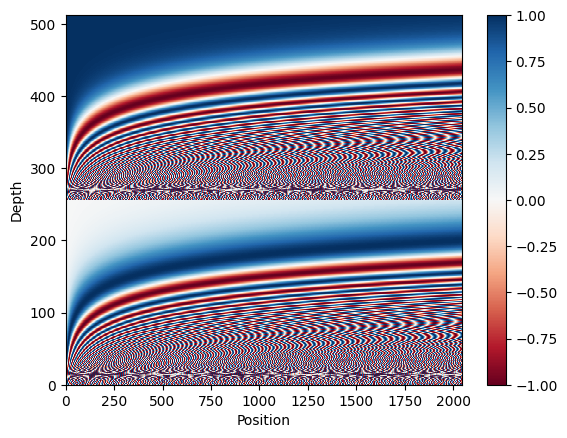

In [85]:
#@title
pos_encoding = positional_encoding(length=2048, depth=512)

# Check the shape.
print(pos_encoding.shape)

# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

위에서 보듯이 위치 이코딩의 정의에 따라 이러한 벡터는 위치 축을 따라 인근 벡터와 잘 정렬됩니다. 아래에서 위치 인코딩 벡터가 정규화되고 `1000` 위치의 벡터는 내적을 통해 다른 모든 벡터와 비교됩니다.

pos_encoding shape:  (2048, 512)
p shape:  (512,)
dots shape:  (2048,)
dots:  tf.Tensor([0.17567033 0.1883244  0.19303918 ... 0.18210521 0.17402971 0.16619758], shape=(2048,), dtype=float32)


(0.0, 1.0)

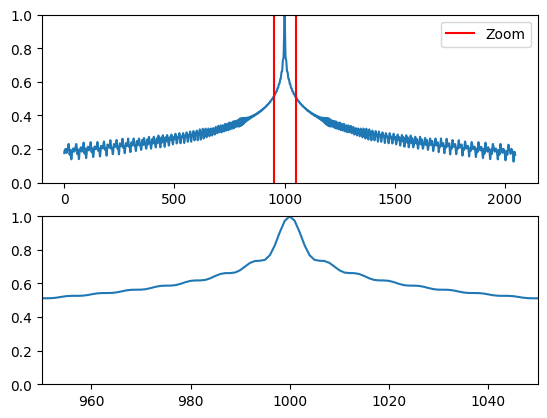

In [86]:
#@title
pos_encoding/=tf.norm(pos_encoding, axis=1, keepdims=True)
print("pos_encoding shape: ", pos_encoding.shape)
p = pos_encoding[1000]
print("p shape: ", p.shape)
dots = tf.einsum('pd,d -> p', pos_encoding, p)  # Dot Product (Cosine Similarity) with respect to 1000th embedding.
print("dots shape: ", dots.shape)
print("dots: ", dots)
plt.subplot(2,1,1)
plt.plot(dots)
plt.ylim([0,1])
plt.plot([950, 950, float('nan'), 1050, 1050],
         [0,1,float('nan'),0,1], color='r', label='Zoom')
plt.legend()
plt.subplot(2,1,2)
plt.plot(dots)
plt.xlim([950, 1050])
plt.ylim([0,1])

위 과정을 좀 더 설명해보자면 다음과 같습니다.:

1. `pos_encoding` 텐서의 L2 Norm (Euclidean Norm)을 계산하여 행 방향으로 정규화합니다. 이는 `tf.norm` 함수를 사용하여 수행되며 `axis=1`을 설정하여 행 방향으로 계산됩니다. 결과는 `pos_encoding` 텐서 자체에 다시 할당됩니다.
2. `pos_encoding` 텐서에서 인덱스 `1000`에 해당하는 위치 인코딩 벡터를 선택하여 변수 `p`에 할당합니다.
3. `tf.einsum('pd,d -> p', pos_encoding, p)`를 사용하여 `pos_encoding` 텐서의 각 위치 인코딩 벡터와 `p` 벡터 사이의 내적을 계산합니다. `einsum` 함수는 요소별 곱셈과 합산 연산을 수행하는 데 사용됩니다. 결과는 `dots` 변수에 할당됩니다.
4. `plt.subplot(2,1,1)`을 사용하여 2행 1열의 서브플롯 그리드를 생성하고 현재 서브플롯을 첫 번째로 설정합니다.
5. `plt.plot(dots)`을 사용하여 계산된 내적 값을 그립니다.
6. `plt.ylim([0,1])`을 사용하여 y축의 범위를 0에서 1로 설정합니다.
7. `plt.plot([950, 950, float('nan'), 1050, 1050], [0,1,float('nan'),0,1], color='k', label='Zoom')`을 사용하여 x값이 950과 1050인 수직 선을 그려서 확대된 영역을 나타냅니다. `float('nan')`은 선에 갭을 만들기 위해 사용됩니다.
    - `[950, 950, float('nan'), 1050, 1050]`: 이 부분은 그래프의 x 좌표에 해당합니다. 여기서는 950과 1050 사이에 수직 선을 그리기 위해 950을 두 번 반복하고, float('nan')을 사용하여 수직 선 사이에 갭을 생성합니다. 'nan'은 "Not a Number"를 의미하는 특수한 값으로, 선 그래프에서 갭을 만들기 위해 사용됩니다.
    - `[0,1,float('nan'),0,1]`: 이 부분은 그래프의 y 좌표에 해당합니다. 여기서는 0과 1 사이에 수직 선을 그리기 위해 0과 1을 반복하고, float('nan')을 사용하여 수직 선 사이에 갭을 생성합니다.
    - `color='r'`: 이 부분은 그래프의 색상을 지정합니다. `r`은 빨간색을 의미합니다. (참고: 검은색은 `k`, 파란색은 `b` 입니다).
    - `label='Zoom'`: 이 부분은 그래프에 대한 레이블을 지정합니다. 여기서는 'Zoom'으로 지정되어 있습니다.
8. `plt.legend()`를 사용하여 범례를 추가합니다.
9. `plt.subplot(2,1,2)`을 사용하여 현재 서브플롯을 두 번째로 설정합니다.
10. `plt.plot(dots)`을 사용하여 내적 값을 다시 그립니다.
11. `plt.xlim([950, 1050])`을 사용하여 x축의 범위를 950에서 1050으로 설정합니다.
12. `plt.ylim([0,1])`을 사용하여 y축의 범위를 0에서 1로 설정합니다.

정리하자면 위 코드는 위치 인코딩 벡터와 `p` 벡터 간의 내적을 계산하고, 그 결과를 시각화하여 내적 값의 분포 및 연관도를 확인하는 작업입니다.

(참고) 위에서 `einsum()` 함수 (연산)에 대해:
`einsum` 연산은 `numpy(np.einsum)`, `torch(torch.einsum)`, `tensorflow(tf.einsum)`과 같이 자주 사용하는 연산 라이브러리에 모두 구현되어 있습니다. 특히 `PyTorch`와 `Tensorflow` 에서는 뉴럴넷을 위한 어떤 임의의 연산 그래프 위에서도 `Back Propagation`이 가능한 형태로 구현되어 있습니다. 세 경우 모두 `einsum(equation, operands)`와 같이 인자로 `equation` 과 `operands`를 받습니다.

`equation(string)`: `equation`은 `operand`의 각 index에 대응하는 소문자로 구성되는 식입니다. 식은 "->" 를 기준으로 왼쪽, 오른쪽이 다른 의미를 지닙니다. 왼쪽에는 `operand`들의 차원을 나열한 것으로 ","를 기준으로 구분됩니다. 오른쪽에는 출력값(Output)의 차원 인덱스들을 나타냅니다. 오른쪽은 생략될 수 있는데, 이 경우 왼쪽에서 정확히 한번만 언급된 알파벳들(합의 축이 아닌 알파벳들)을 순서대로 나열한 것으로 내부적으로 정의됩니다. 출력값에 표현되지 않은 인덱스들은 `operand`들을 곱한 후 해당 인덱스를 기준으로 더해집니다.

`operands(Tensor)`: 해당 연산을 수행할 대상들입니다.

예를 들어 아래에 사용된 문자열 `pd,d -> p`를 분석해 보겠습니다.

문자열 'pd,d'는 입력 텐서의 차원을 지정합니다. 여기서 'pd'는 pos_encoding이 두 가지 차원, 즉 첫 번째 차원 p와 두 번째 차원 d를 가지고 있음을 나타냅니다. 'd'는 p가 단 하나의 차원만을 갖는다는 것을 나타냅니다.

화살표 오른쪽에 쓰인 문자열 'p'는 출력 텐서의 차원을 지정합니다. 여기서는 결과 내적 텐서가 단 하나의 차원만을 갖는다는 것을 나타냅니다.

위의 위치 인코딩 벡터를 얻는 로직을 사용하여 토큰의 임베딩 벡터를 조회하고 위치 벡터를 추가하는 `PositionEmbedding` 레이어를 만듭니다:

In [87]:
class PositionalEmbedding(tf.keras.layers.Layer):
    # vocab_size: 어휘 사전의 크기, d_model: 임베딩의 차원
    def __init__(self, vocab_size, d_model):
        super().__init__()
        print("PositionalEmbedding __init__()")
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        print("PositionalEmbedding call()")
        length = tf.shape(x)[1]
        print("length = tf.shape(x)[1]: ", length)
        x = self.embedding(x)
        print("x = self.embedding(x) shape: ", x.shape)
        # This factor sets the relative scale of the embedding and positional_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        print("x *= (scalar)tf.math.sqrt(tf.cast(self.d_model, tf.float32)) shape: ", x.shape)
        print("self.pos_encoding shape (pre): ", self.pos_encoding.shape)
        y = self.pos_encoding[tf.newaxis, :length, :]
        print("y = self.pos_encoding[tf.newaxis, :length, :] shape: ", y.shape)
        x = x + y
        print("(아래에서 참고) 1차원=배치 사이즈, 2차원= 시퀀스 길이, 3차원, 임베딩 벡터 길이")
        print("x = x + self.pos_encoding[tf.newaxis, :length, :1]: ", x.shape)
        return x

`PositionalEmbedding` 클래스의 `call` 메서드를 좀 더 살펴보겠습니다.
1. `length = tf.shape(x)[1]`: 입력 데이터 x의 길이를 구하여 length 변수에 할당하는 부분입니다.
2. `x = self.embedding(x)`: 입력 데이터 x를 임베딩하는 부분입니다. `self.embedding`은 `tf.keras.layers.Embedding`을 사용하여 입력 토큰을 임베딩하는 레이어입니다.
3. `x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))`: 임베딩된 결과에 `tf.math.sqrt(tf.cast(self.d_model, tf.float32))`를 곱하여 임베딩과 위치 인코딩의 상대적인 스케일을 조절하는 부분입니다. `self.d_model`은 임베딩 차원의 크기를 담고있는 인스턴스 변수입니다.
4. `x = x + self.pos_encoding[tf.newaxis, :length, :]`: 임베딩된 결과에 위치 인코딩 벡터를 더하는 부분입니다. `self.pos_encoding`은 `positional_encoding` 함수를 호출하여 위치 인코딩 벡터를 생성하여 저장하는 인스턴스 변수입니다. `tf.newaxis`를 사용하여 차원을 추가하고, `:length, :]`를 사용하여 길이에 맞게 슬라이싱합니다.
5. `return x`: 최종적으로 임베딩된 결과를 반환하는 부분입니다.

즉, 위의 코드는 `PositionalEmbedding` 클래스의 `call` 메서드에서 입력 데이터를 임베딩하고 위치 인코딩을 적용하는 과정을 수행합니다. 이를 통해 모델이 단어의 순서나 위치에 민감하게 반응할 수 있도록 도와줍니다.

> 참고: [원본 논문](https://arxiv.org/pdf/1706.03762.pdf), 섹션 3.4 및 5.1에서는 소스 언어와 대상 언어 모두에 대해 단일 토크나이저 및 가중치 매트릭스를 사용합니다. 이 튜토리얼에서는 두 개의 별도 토크나이저와 가중치 행렬을 사용합니다.

In [88]:
embed_pt = PositionalEmbedding(vocab_size=tokenizers.pt.get_vocab_size(), d_model=512)
embed_en = PositionalEmbedding(vocab_size=tokenizers.en.get_vocab_size(), d_model=512)

print("===")
print("Embedding Portuguese")
pt_emb = embed_pt(pt)

print("===")
print("Embedding English")
en_emb = embed_en(en)

PositionalEmbedding __init__()
positional_encoding() called.
positions shape:  (2048, 1)
depths shape (half):  (1, 256)
PositionalEmbedding __init__()
positional_encoding() called.
positions shape:  (2048, 1)
depths shape (half):  (1, 256)
===
Embedding Portuguese
PositionalEmbedding call()
length = tf.shape(x)[1]:  tf.Tensor(94, shape=(), dtype=int32)
x = self.embedding(x) shape:  (64, 94, 512)
x *= (scalar)tf.math.sqrt(tf.cast(self.d_model, tf.float32)) shape:  (64, 94, 512)
self.pos_encoding shape (pre):  (2048, 512)
y = self.pos_encoding[tf.newaxis, :length, :] shape:  (1, 94, 512)
(아래에서 참고) 1차원=배치 사이즈, 2차원= 시퀀스 길이, 3차원, 임베딩 벡터 길이
x = x + self.pos_encoding[tf.newaxis, :length, :1]:  (64, 94, 512)
===
Embedding English
PositionalEmbedding call()
length = tf.shape(x)[1]:  tf.Tensor(74, shape=(), dtype=int32)
x = self.embedding(x) shape:  (64, 74, 512)
x *= (scalar)tf.math.sqrt(tf.cast(self.d_model, tf.float32)) shape:  (64, 74, 512)
self.pos_encoding shape (pre):  (2048, 512)
y = sel

내부적으로 위에서 수행한 임베딩은 마스크 텐서((배치 사이즈, 시퀀스_길이)의 2D 텐서)을 생성하고 이를 임베딩 레이어에서 반환된 텐서 출력에 연결합니다.
즉, 임베딩 텐서의 `_kara_mask` 속성으로 0으로 패딩된 값이 적절하게 마스크 되었는지 확인할 수 있습니다.
마스크가 된 곳은 `False`로 표시되며 학습 시 제외됩니다. 

In [89]:
en_emb._keras_mask

<tf.Tensor: shape=(64, 74), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

### 더하기 및 정규화 (Add and normalize)

<table>
<tr>
  <th colspan=2>더하기 및 정규화</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Add+Norm.png"/>
  </td>
</tr>
</table>

`Add & Norm` 블록은 모델 전체에 포함되어 있습니다. 각각은 `잔차 연결 (Residual Connection 혹은 Skip Connection이라고도 부릅니다)`을 결합하고 해당 결과를 `LayerNormalization` 레이어로 통과 시킵니다.

코드를 구성하는 가장 쉬운 방법은 이러한 잔차 연결 블록을 중심으로 코드를 구성하는 것입니다. 다음 섹션에서는 각각에 대한 사용자 정의 레이어 클래스를 정의합니다.

`Add & Norm` 블록은 학습이 효과적으로 수행될 수 있도록 해줍니다. 잔차 연결은 그래디언트에 대한 직접적인 경로를 제공하며, 정규화는 합리적인 출력의 규모를 유지합니다.

### 기본 어텐션 레이어

어텐션 레이어는 모델 전반에 걸쳐 사용됩니다. 어텐션이 구성되는 방식을 제외하고는 모두 동일합니다. 각각의 어텐션 레이어는 `layers.MultiHeadAttention`, `layers.LayerNormalization` 및 `layers.Add`를 포함합니다. 

<table>
<tr>
  <th colspan=2>The base attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/BaseAttention.png"/>
  </td>
</tr>
</table>

어텐션 레이어를 구현하려면 구성 레이어를 포함하는 간단한 기본 클래스로 시작하는 것이 좋습니다. 복잡한 유스 케이스는 서브 클래스로 구현하는 것이 좋으며, 코드 양이 늘어나지만 모델의 과업을 명확하게 유지합니다.

In [90]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

#### 어텐션 동작 방식 살펴보기

각 레이어의 세부 사항에 들어가기 전에 어텐션이 어떻게 동작하는지에 대해 빠르게 살펴보도록 하겠습니다.

<table>
<tr>
  <th colspan=1>기본 어텐션 레이더</th>
</tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/BaseAttention-new.png"/>
  </td>
</tr>
</table>

입력에는 두 가지가 있습니다.

1. 쿼리 시퀀스; 처리되는 시퀀스; 어텐션을 수행하는 시퀀스 (하단).
2. 컨텍스트 시퀀스; 어텐션이 적용되는 시퀀스 (왼쪽).

출력은 쿼리 시퀀스와 같은 형태를 가집니다.

일반적으로 이 작업은 사전 조회에 비교되기도 하는데, 매우 **퍼지**하고, **독특**하며, **벡터화**된 사전 조회라고 보시면 됩니다.

다음은 일반적인 파이썬 딕셔너리 변수를 선언하여, 3 개의 키와 3 개의 값이 단일 쿼리로 전달됩니다.

```
d = {'color': 'blue', 'age': 22, 'type': 'pickup'}
result = d['color']
```

- `query`는 찾으려고 하는 단어입니다.
- `key`는 사전에 어떤 종류의 정보가 있는지에 대한 정보입니다.
- `value`는 해당 정보입니다.

일반적인 딕셔너리에서 `query`를 찾을 때 사전은 일치하는 `key`를 찾아 연관된 `value`를 반환합니다.
`query`에 일치하는 `key` 있거나 없을 수도 있습니다.
키가 완벽하게 일치하지 않아도 되는 **퍼지** 사전을 상상할 수 있습니다. 
예를 들어 위의 사전에서 `d["species"]`를 조회한다면 `"pickup"`이 반환하기를 원할 수 있습니다.

어텐션 레이어는 이와 같이 퍼지 조회를 수행하지만 최상의 키를 찾는 것은 아닙니다. 
`query`가 각각의 `key`와 얼마나 잘 일치하는지에 따라 `values` 값을 조합합니다.

이것이 어떻게 작도할까요? 어텐션 레이어에서 `query`, `key` 및 `value`는 모두 벡터입니다.
해시 조회를하는 대신 어텐션 레이어는 `query`와 `key` 벡터를 결합하여 이들이 얼마나 잘 "어울리는 지"를 결정하며 이를 "어텐션 스코어"라고 합니다.
레이어는 "어텐션 스코어"에 의해 가중치가 조절된 `values`의 Weighted Sum을 반환합니다.

쿼리-시퀀스는 각 위치에 대해 `query` 벡터를 제공합니다.
컨텍스트 시퀀스는 사전 역할을합니다. 컨텍스트 시퀀스의 각 위치에서 `key` 및 `value`벡터를 제공합니다. 
입력 벡터는 직접 사용되지 않습니다. `layers.MultiHeadAttention` 계층에서는 입력 벡터를 사용하기 전에 `layers.Dense`로 프로젝션합니다.

### 교차 (Cross) 어텐션 레이더

교차 어텐션 레이너는 트랜스포머의 핵심 요소입니다. 이 레이너에서는 인코더와 디코더가 연결됩니다. 이 계층은 모델에서 가장 직관적인 (straightforward) 어텐션을 사용합니다.

<table>
<tr>
  <th colspan=1>교차 어텐션 레이어</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention.png"/>
  </td>
</tr>
</table>

이를 구현하기 위해 `mha` 레이어를 호출할 때 대상 시퀀스 `x`를 `query`로, `context` 시퀀스를 `key/value` 로 전달합니다.

In [91]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)
   
    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

아래그림은 이 계층을 통해 정보가 어떻게 흐르는지를 보여줍니다. 컬름은 컨텍스트 시퀀스의 가중치 합 (Weight Sum)을 나타냅니다.

단순하게 표현하기 위해 잔류 연결 (Residual Connection)은 표시하지 않았습니다.

<table>
<tr>
  <th>교차 어텐션 레이어</th>
</tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention-new-full.png"/>
  </td>
</tr>
</table>

출력의 길이는 컨텍스트 `key/value` 시퀀스의 길이가 아닌 `query` 시퀀스의 길이입니다.

전체 "어텐션 가중치" 매트릭스를 그릴 필요가 없으므로 다이어그램을 더 단순하게 표현하면 아래와 같습니다.
요점은 각각의 `query` 위치가 컨텍스트의 모든 `key/value` 쌍을 볼 수 있지만 쿼리간에 정보가 교환되지 않는다는 것입니다.

<table>
<tr>
  <th>각 쿼리는 모든 컨텍스트를 볼 수 있음</th>
</tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention-new.png"/>
  </td>
</tr>
</table>

아래 샘플 입력에 대해 테스트해 봅니다:

In [92]:
sample_ca = CrossAttention(num_heads=2, key_dim=512)

print("(배치 사이즈, 시퀀스 (혹은 토큰) 길이, 임베딩 벡터 길이)")
print(pt_emb.shape)
print(en_emb.shape)
print(sample_ca(en_emb, pt_emb).shape)

(배치 사이즈, 시퀀스 (혹은 토큰) 길이, 임베딩 벡터 길이)
(64, 94, 512)
(64, 74, 512)
(64, 74, 512)


### 글로벌 셀프 어텐션 레이어

이 레이어는 컨텍스트 시퀀스를 처리하고 전체 길이에 걸쳐 정보를 전파합니다.

<table>
<tr>
  <th colspan=1>글로벌 셀프 어텐션 레이어</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention.png"/>
  </td>
</tr>
</table>

번역이 수행되는 동안 컨텍스트 시퀀스는 정해져 있으므로 정보는 양방향으로 흐를 수 있습니다. 

트랜스포머와 셀프 어텐션 기법이 도입되기 전에는 일반적으로 RNN 또는 CNN 모델을 사용하여 작업을 수행했습니다.

<table>
<tr>
  <th colspan=1>양방향 RNN과 CNN</th>
</tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/RNN-bidirectional.png"/>
  </td>
</tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/CNN.png"/>
  </td>
</tr>
</table>

RNN과 CNN에는 제약 사항이 있습니다.

- RNN을 통해 정보는 시퀀스를 가로 질러 흐르도록 허용하지만, 많은 처리 단계를 통과하여, 역전파 시에 기울기가 소실되며 (Vanishing Gradient), 각 단계가 순차적으로 실행되어야 하므로 최신 병렬 장치를 활용할 수 없습니다. 
- CNN에서 각 위치는 병렬로 처리 될 수 있지만 제한된 수용 필드만 제공합니다. 수용 필드는 CNN 층의 수와 함께 선형으로 증가하므로, 시퀀스에서 정보를 전송하기 위해 여러 컨볼루션 레이어를 쌓아야 합니다. ([Wavenet](https://arxiv.org/abs/1609.03499) 이를 확장된 컨볼루션 (Dilated Convolutio) 기법을 통해 경감합니다). 

반면에 글로벌 셀프 어텐션 레이어에서는 모든 시퀀스 요소가 몇 가지 작업만으로 모든 다른 시퀀스 요소를 직접 액세스할 수 있으며 모든 출력은 병렬로 계산할 수 있습니다. 

이 레이어를 구현하려면 `mha` 레이어의 `query`와 `value` 매개변수에 공히 `x`를 전달하면됩니다:

In [93]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [94]:
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

print("(배치 사이즈, 시퀀스 (혹은 토큰) 길이, 임베딩 벡터 길이)")
print(pt_emb.shape)
print(sample_gsa(pt_emb).shape)

(배치 사이즈, 시퀀스 (혹은 토큰) 길이, 임베딩 벡터 길이)
(64, 94, 512)
(64, 94, 512)


교차 어텐션 레이어에서와 동일하게 아래와 같이 그릴 수 있습니다:

<table>
<tr>
  <th colspan=1>글로벌 셀프 어텐션 레이어</th>
<tr>
<tr>
  <td>
   <img width=330 src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention-new-full.png"/>
  </td>
</tr>
</table>

간결한 그림을 위해 다시 한번 잔류 연결은 생략되었습니다.

<table>
<tr>
  <th colspan=1>글로벌 셀프 어텐션 레이어</th>
<tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention-new.png"/>
  </td>
</tr>
</table>

### 디코더 (인과; Causal) 셀프 어텐션 레이어

이 층은 출력 시퀀스에 대해 글로벌 셀프 어텐션 레이어와 유사한 작업을 수행합니다.

<table>
<tr>
  <th colspan=1>디코더 셀프 어텐션 레이어</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/CausalSelfAttention.png"/>
  </td>
</tr>
</table>

이것은 인코더의 글로벌 셀프 어텐션 레이어와는 다르게 처리되어야 합니다. 

트랜스포머는 "자동 회귀" (autoregressive) 모델입니다. 한 번에 하나의 토큰씩 텍스트를 생성하고 다음 입력으로 다시 주입합니다. 이 과정을 `효율적`으로 만들기 위해, 트랜스포머 모델은 각 시퀀스 요소의 출력이 이전 시퀀스 요소에만 의존하도록 보장해야 합니다. 이로 인해 트랜스포머 모델을 "인과적 (causal)" 모델이라고 합니다.

단일 방향 RNN도 정의에 따라 인과적입니다. 인과 관계 컨볼루션을 만드려면 입력을 패딩하고 출력이 올바르게 정렬 혹은 마스킹하면 됩니다 (`layers.Conv1D(padding='causal')` 사용).

<table>
<tr>
  <th colspan=1>인과적 RNN과 CNN</th>
</tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/RNN.png"/>
  </td>
</tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/CNN-causal.png"/>
  </td>
</tr>
</table>

A causal model is efficient in two ways: 

1. In training, it lets you compute loss for every location in the output sequence while executing the model just once.
2. During inference, for each new token generated you only need to calculate its outputs, the outputs for the previous sequence elements can be reused.
  - For an RNN you just need the RNN-state to account for previous computations (pass `return_state=True` to the RNN layer's constructor).
  - For a CNN you would need to follow the approach of [Fast Wavenet](https://arxiv.org/abs/1611.09482)
인과적 모델은 두 가지 면에서 효율적입니다:

1. 학습 시 모델을 한 번만 실행하면서 출력 시퀀스의 모든 위치에 대한 손실을 계산할 수 있습니다. 
2. 추론하는 동안 생성된 각각의 새로운 토큰을 위해 출력을 계산하면 되며, 이전의 출력을 재사용할 수 있습니다.
  - RNN의 경우 이전의 계산 정보를 담는 RNN-State 만 있으면 됩니다 (RNN 레이어의 생성자에 대해 `return_state=True` 로 설정). 
  - CNN의 경우 [Fast Wavenet](https://arxiv.org/abs/1611.09482)의 접근 방식을 따릅니다.

인과 셀프 어텐선 레이어를 구축하려면 어텐션 스코어를 계산하고 어텐션 `value` 값으로 합산할 때 적절히 마스킹하여야 합니다.

`use_causal_mask=True`를 `MultiHeadAttention` 레어어로 전달하면 이 과정이 자동으로 처리됩니다.

In [95]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

인과 마스크는 각 위치가 이전 위치에만 액세스 할 수 있도록 합니다.
즉, `Future Token`의 어텐션 가중치 값은 계산되기는 하지만 마스킹됩니다.

<table>
<tr>
  <th colspan=1>인과적 셀프 어텐션 레이어</th>
<tr>
<tr>
  <td>
   <img width=330 src="https://www.tensorflow.org/images/tutorials/transformer/CausalSelfAttention-new-full.png"/>
  </td>
</tr>
</table>

이전과 같이 잔류 연결은 단순하게 표현하기 위해 생략되었습니다.

이 층의 더 컴팩트 한 표현은 다음과 같습니다.

<table>
</tr>
  <th colspan=1>인과적 셀프 어텐션 레이어</th>
<tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/CausalSelfAttention-new.png"/>
  </td>
</tr>
</table>

레이어를 테스트해 봅시다:

In [96]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)

print("(배치 사이즈, 시퀀스 (혹은 토큰) 길이, 임베딩 벡터 길이)")
print(en_emb.shape)
print(sample_csa(en_emb).shape)

(배치 사이즈, 시퀀스 (혹은 토큰) 길이, 임베딩 벡터 길이)
(64, 74, 512)
(64, 74, 512)


앞서 나오는 시퀀스 요소로부터의 출력은 이후 요소에 의존하지 않으므로 레이어를 적용하기 전후에 각 요소를 자르거나 다듬는 것은 중요하지 않습니다.

In [97]:
out1 = sample_csa(embed_en(en[:, :3]))
print("out1.shape: ", out1.shape)
out2 = sample_csa(embed_en(en))[:, :3]
print("out2.shape: ", out2.shape)

tf.reduce_max(abs(out1 - out2)).numpy()

PositionalEmbedding call()
length = tf.shape(x)[1]:  tf.Tensor(3, shape=(), dtype=int32)
x = self.embedding(x) shape:  (64, 3, 512)
x *= (scalar)tf.math.sqrt(tf.cast(self.d_model, tf.float32)) shape:  (64, 3, 512)
self.pos_encoding shape (pre):  (2048, 512)
y = self.pos_encoding[tf.newaxis, :length, :] shape:  (1, 3, 512)
(아래에서 참고) 1차원=배치 사이즈, 2차원= 시퀀스 길이, 3차원, 임베딩 벡터 길이
x = x + self.pos_encoding[tf.newaxis, :length, :1]:  (64, 3, 512)
out1.shape:  (64, 3, 512)
PositionalEmbedding call()
length = tf.shape(x)[1]:  tf.Tensor(74, shape=(), dtype=int32)
x = self.embedding(x) shape:  (64, 74, 512)
x *= (scalar)tf.math.sqrt(tf.cast(self.d_model, tf.float32)) shape:  (64, 74, 512)
self.pos_encoding shape (pre):  (2048, 512)
y = self.pos_encoding[tf.newaxis, :length, :] shape:  (1, 74, 512)
(아래에서 참고) 1차원=배치 사이즈, 2차원= 시퀀스 길이, 3차원, 임베딩 벡터 길이
x = x + self.pos_encoding[tf.newaxis, :length, :1]:  (64, 74, 512)
out2.shape:  (64, 3, 512)


5.9604645e-07

참고 : Keras는 내부적으로 마스크가 적용된 유효하지 않은 위치의 출력 값은 잘 정의하고 있지 않습니다. 따라서 위의 내용은 마스크가 적용된 영역에서는 유효하지 않을 수 있습니다.

### 피드 포워드 네트워크

트랜스포머는 또한 인코더와 디코더 모두에서 Point-wise 피드 포워드 네트워크를 가지고 있습니다.

<table>
<tr>
  <th colspan=1>피드 포워드 네트워크</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/FeedForward.png"/>
  </td>
</tr>
</table>

피드 포워드 네트워크는 중간에 ReLU Activation이 포함된 두 개의 선형 레이어 (`tf.keras.layers.Dense`)와 드롭 아웃 레이어 (Overfitting 방지)로 구성됩니다. 어텐션 레이어와 마찬가지로 여기에도 잔류 연결 및 정규화가 (`Add and Normalization`) 포함됩니다:

In [98]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x) 
    return x


레이어를 테스트해 보겠습니다. 출력은 입력과 동일한 모양입니다:

In [99]:
sample_ffn = FeedForward(512, 2048)

print("(배치 사이즈, 시퀀스 (혹은 토큰) 길이, 임베딩 벡터 길이)")
print(en_emb.shape)
print(sample_ffn(en_emb).shape)

(배치 사이즈, 시퀀스 (혹은 토큰) 길이, 임베딩 벡터 길이)
(64, 74, 512)
(64, 74, 512)


### 인코더 레이어

인코더에는 `N` 개의 인코더 레이어 스택이 포함되어 있습니다. 그리고 각 `EncoderLayer` 에는 `GlobalSelfAttention` 및 `FeedForward` 레이어가 포함되어 있습니다:

<table>
<tr>
  <th colspan=1>인코더 레이어</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/EncoderLayer.png"/>
  </td>
</tr>
</table>

아래 클래스 `EncoderLayer`가 인코더 레이어를 정의하고 있습니다:

In [100]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

테스트해 보면 역시 출력은 입력과 같은 모양을 갖습니다:

In [101]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

print("(배치 사이즈, 시퀀스 (혹은 토큰) 길이, 임베딩 벡터 길이)")
print(pt_emb.shape)
print(sample_encoder_layer(pt_emb).shape)

(배치 사이즈, 시퀀스 (혹은 토큰) 길이, 임베딩 벡터 길이)
(64, 94, 512)
(64, 94, 512)


### 인코더 전체

이제 전체 인코더를 빌드해 보겠습니다.

<table>
<tr>
  <th colspan=1>인코더</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Encoder.png"/>
  </td>
</tr>
</table>

전체 인코더는 다음으로 이루어져 있습니다:

- 입력을 받아 수행되는 `PositionalEmbedding` 레이어.
- `EncoderLayer` 레이어 스택.

In [102]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)

        self.enc_layers = [EncoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate)
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        # `x` is token-IDs shape: (batch, seq_len)
        x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

        # Add dropout.
        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        return x  # Shape `(batch_size, seq_len, d_model)`.

인코더를 테스트해 봅니다:

In [103]:
# Instantiate the encoder.
sample_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8500)

sample_encoder_output = sample_encoder(pt, training=False)

# Print the shape.
print(pt.shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

PositionalEmbedding __init__()
positional_encoding() called.
positions shape:  (2048, 1)
depths shape (half):  (1, 256)
PositionalEmbedding call()
length = tf.shape(x)[1]:  tf.Tensor(94, shape=(), dtype=int32)
x = self.embedding(x) shape:  (64, 94, 512)
x *= (scalar)tf.math.sqrt(tf.cast(self.d_model, tf.float32)) shape:  (64, 94, 512)
self.pos_encoding shape (pre):  (2048, 512)
y = self.pos_encoding[tf.newaxis, :length, :] shape:  (1, 94, 512)
(아래에서 참고) 1차원=배치 사이즈, 2차원= 시퀀스 길이, 3차원, 임베딩 벡터 길이
x = x + self.pos_encoding[tf.newaxis, :length, :1]:  (64, 94, 512)
(64, 94)
(64, 94, 512)


### 디코더 레이어

디코더 스택은 약간 더 복잡하며 각각의 `DecoderLayer`는 '`CausalSelfAttention`, `CrossAttention`, 및 `FeedForward` 레이어를 포함합니다:

<table>
<tr>
  <th colspan=1>디코더 레이어</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/DecoderLayer.png"/>
  </td>
</tr>
</table>

In [104]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()

        self.causal_self_attention = CausalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate
        )

        self.cross_attention = CrossAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate
        )

        self.ffn = FeedForward(d_model, dff)

    def call(self, x, context):
        x = self.causal_self_attention(x=x)
        x = self.cross_attention(x=x, context=context)

        # Cache the last attention scores for plotting later
        self.last_attn_scores = self.cross_attention.last_attn_scores

        x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
        return x

디코더 레이어를 테스트해 봅니다:

In [105]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output = sample_decoder_layer(x=en_emb, context=pt_emb)

print(en_emb.shape)  # Shape of English embeddings
print(pt_emb.shape)  # Shape of Portuguese embeddings
print(sample_decoder_layer_output.shape)  # Shape of the output from the decoder layer

(64, 74, 512)
(64, 94, 512)
(64, 74, 512)


### 디코더 전체

`Encoder`와 유사하게 `Decoder`는 `PositionalEmbedding` 레이어와 `DecoderLayer`로 구성됩니다:

<table>
<tr>
  <th colspan=1>디코더</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Decoder.png"/>
  </td>
</tr>
</table>

인코더와 유사하게 아래와 같이 `tf.keras.layers.Layer`를 상속하여 디코더를 정의합니다:

In [106]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dec_layers = [DecoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate)
                           for _ in range(num_layers)]

        self.last_attn_scores = None

    def call(self, x, context):
        # `x` is token-IDs shape (batch, target_seq_len)
        x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.dec_layers[i](x, context)

        self.last_attn_scores = self.dec_layers[-1].last_attn_scores

        # The shape of x is (batch_size, target_seq_len, d_model).
        return x

디코더를 테스트해 봅니다:

In [107]:
# Instantiate the decoder
sample_decoder = Decoder(
    num_layers=4,
    d_model=512,
    num_heads=8,
    dff=2048,
    vocab_size=8000
)

# Get the output
output = sample_decoder(x=en, context=pt_emb)

# Print the shapes
print(en.shape)
print(pt_emb.shape)
print(output.shape)

PositionalEmbedding __init__()
positional_encoding() called.
positions shape:  (2048, 1)
depths shape (half):  (1, 256)
PositionalEmbedding call()
length = tf.shape(x)[1]:  tf.Tensor(74, shape=(), dtype=int32)
x = self.embedding(x) shape:  (64, 74, 512)
x *= (scalar)tf.math.sqrt(tf.cast(self.d_model, tf.float32)) shape:  (64, 74, 512)
self.pos_encoding shape (pre):  (2048, 512)
y = self.pos_encoding[tf.newaxis, :length, :] shape:  (1, 74, 512)
(아래에서 참고) 1차원=배치 사이즈, 2차원= 시퀀스 길이, 3차원, 임베딩 벡터 길이
x = x + self.pos_encoding[tf.newaxis, :length, :1]:  (64, 74, 512)


(64, 74)
(64, 94, 512)
(64, 74, 512)


In [108]:
sample_decoder.last_attn_scores.shape  # (batch, heads, target_seq, input_seq)

TensorShape([64, 8, 74, 94])

(드디어) 인코더와 디코더를 모두 정의하였으므로 전체 트랜스포머 모델을 구축하고 학습을 시켜봅니다.

## (마침내) 트랜스포머


이제 우리는 `Encoder`와 `Decoder`를 가지고 있습니다. `트랜스포머` 모델을 완성하려면 이것들을 결합하고 각 위치의 결과 벡터를 출력 토큰 확률로 변환하는 최종적인 선형 `Dense` 레이어를 추가해야 합니다.

디코더의 출력은 이 최종 선형 층에 대한 입력입니다.

<table>
<tr>
  <th colspan=1>트랜스포머</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png"/>
  </td>
</tr>
</table>

하나의 `Encoder`와 `Decoder` 레이러를 가진 `트랜스포머`는 [RNN+어텐션 튜토리얼](https://www.tensorflow.org/text/tutorials/nmt_with_attention)에 제시된 모델과 거의 똑같이 보입니다. 멀티 레이어 트랜스포머에는 더 많은 레이어가 있지만 근본적으로 같은 작업을 수행합니다.

<table>
<tr>
  <th colspan=1>단일 계층 트랜스포머</th>
  <th colspan=1>4-계층 트랜스포머</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-compact.png"/>
  </td>
  <td rowspan=3>
   <img width=330 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-4layer-compact.png"/>
  </td>
</tr>
<tr>
  <th colspan=1>RNN+어텐션 모델</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/RNN+attention-compact.png"/>
  </td>
</tr>
</table>

`tf.keras.Model`을 확장하여 `트랜스포머`를 만듭니다: 

> 참고: [원본 논문](https://arxiv.org/pdf/1706.03762.pdf), 3.4 절은 임베딩 층과 최종 선형 레이어 사이에 가중치 매트릭스를 공유합니다. 모델을 단순하게 유지하기 위해 이 문서에서는 두 개의 별도의 가중치 행렬을 사용합니다.

In [109]:
class Transformer(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, dropout_rate=0.1):
        super().__init__()

        self.encoder = Encoder(
            num_layers=num_layers,
            d_model=d_model,
            num_heads=num_heads,
            dff=dff,
            vocab_size=input_vocab_size,
            dropout_rate=dropout_rate
        )

        self.decoder = Decoder(
            num_layers=num_layers,
            d_model=d_model,
            num_heads=num_heads,
            dff=dff,
            vocab_size=target_vocab_size,
            dropout_rate=dropout_rate
        )

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inputs):
        context, x = inputs

        context = self.encoder(context)  # (batch_size, context_len, d_model)
        x = self.decoder(x, context)  # (batch_size, target_len, d_model)

        logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

        try:
            del logits._keras_mask  # Drop the keras mask, so it doesn't scale the losses/metrics.
        except AttributeError:
            pass

        return logits  # Return the final output and the attention weights.

### 하이퍼파라미터

이 모델을 작고 비교적 빠르게 만들기 위해, 내부적으로 레이어의 수 (`num_layers`), 임베딩의 차원 (`d_model`) 및 `FeeForward` 레이어의 차원 (`dff`)의 차원을 의도적으로 줄여서 구현하였습니다.

트랜스포머의 원본 논문에서 설명된 기본 모델은 `num_layers=6`, `d_model = 512`, 그리고 `dff=2048`을 사용하였습니다.

셀프 어텐션 헤드는 동일하게 유지하였습니다 (`num_heads=8`).

In [110]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

### 한번 시도해 봅시다!

`Transform` 모델을 Instantiate합니다:

In [111]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    dropout_rate=dropout_rate)

PositionalEmbedding __init__()
positional_encoding() called.
positions shape:  (2048, 1)
depths shape (half):  (1, 64)
PositionalEmbedding __init__()
positional_encoding() called.
positions shape:  (2048, 1)
depths shape (half):  (1, 64)


Test it:

In [112]:
output = transformer((pt, en))

print("en.shape: ", en.shape)
print("pt.shape: ", pt.shape)

print("===")
print("(batch_size, target_len, target_vocab_size)")
print("output.shape: ", output.shape)

PositionalEmbedding call()
length = tf.shape(x)[1]:  tf.Tensor(94, shape=(), dtype=int32)
x = self.embedding(x) shape:  (64, 94, 128)
x *= (scalar)tf.math.sqrt(tf.cast(self.d_model, tf.float32)) shape:  (64, 94, 128)
self.pos_encoding shape (pre):  (2048, 128)
y = self.pos_encoding[tf.newaxis, :length, :] shape:  (1, 94, 128)
(아래에서 참고) 1차원=배치 사이즈, 2차원= 시퀀스 길이, 3차원, 임베딩 벡터 길이
x = x + self.pos_encoding[tf.newaxis, :length, :1]:  (64, 94, 128)
PositionalEmbedding call()
length = tf.shape(x)[1]:  tf.Tensor(74, shape=(), dtype=int32)
x = self.embedding(x) shape:  (64, 74, 128)
x *= (scalar)tf.math.sqrt(tf.cast(self.d_model, tf.float32)) shape:  (64, 74, 128)
self.pos_encoding shape (pre):  (2048, 128)
y = self.pos_encoding[tf.newaxis, :length, :] shape:  (1, 74, 128)
(아래에서 참고) 1차원=배치 사이즈, 2차원= 시퀀스 길이, 3차원, 임베딩 벡터 길이
x = x + self.pos_encoding[tf.newaxis, :length, :1]:  (64, 74, 128)


en.shape:  (64, 74)
pt.shape:  (64, 94)
===
(batch_size, target_len, target_vocab_size)
output.shape:  (64, 74, 7010)


In [113]:
print("마지막 디코더 레이어의 마지막 어텐션 스코어")
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)
print(attn_scores)

마지막 디코더 레이어의 마지막 어텐션 스코어
(64, 8, 74, 94)
tf.Tensor(
[[[[0.02809407 0.02802913 0.02806939 ... 0.         0.
    0.        ]
   [0.02800319 0.02768715 0.02792791 ... 0.         0.
    0.        ]
   [0.02796021 0.02762632 0.02763241 ... 0.         0.
    0.        ]
   ...
   [0.0106383  0.0106383  0.0106383  ... 0.0106383  0.0106383
    0.0106383 ]
   [0.0106383  0.0106383  0.0106383  ... 0.0106383  0.0106383
    0.0106383 ]
   [0.0106383  0.0106383  0.0106383  ... 0.0106383  0.0106383
    0.0106383 ]]

  [[0.02769227 0.02766168 0.02790488 ... 0.         0.
    0.        ]
   [0.02730157 0.02746037 0.02750155 ... 0.         0.
    0.        ]
   [0.0274095  0.02719689 0.02746869 ... 0.         0.
    0.        ]
   ...
   [0.0106383  0.0106383  0.0106383  ... 0.0106383  0.0106383
    0.0106383 ]
   [0.0106383  0.0106383  0.0106383  ... 0.0106383  0.0106383
    0.0106383 ]
   [0.0106383  0.0106383  0.0106383  ... 0.0106383  0.0106383
    0.0106383 ]]

  [[0.02782487 0.02790795 0.02751438

모델 요약 출력:

In [114]:
transformer.summary()

Model: "transformer_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_3 (Encoder)         multiple                  3632768   
                                                                 
 decoder_3 (Decoder)         multiple                  5647104   
                                                                 
 dense_77 (Dense)            multiple                  904290    
                                                                 
Total params: 10184162 (38.85 MB)
Trainable params: 10184162 (38.85 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# tf.keras.utils.plot_model(transformer, to_file='transformer.png', show_shapes=True)

아래 코드를 통해 모델 전체에 정의된 파라미터 수를 확인할 수 있습니다.
각 레이어를 순회하면서 레이어에 정의된 파라미터 (가중치; Weight) 정보를 살펴 보겠습니다.

<table>
<tr>
  <th colspan=1>트랜스포머</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png"/>
  </td>
</tr>
</table>

(정보) 이 모델에 구축된 파라미터 갯수를 계산하는 로직은 아래와 같습니다.<br>
* 전체 파라미터 수: 10,184,162 = 인코더 파라미터 3,632,768 + 디코더 파라미터 5,647,104 + 출력 레이어 파라미터 904,290
1. 인코더: 입력 (포르투갈어) 임베딩 레이어 파라미터 수 + 어텐션 레이어 4개의 총 파라미터 수 = 993,920 + 2,638,848 = **<u>3,632,768</u>**<br>
   * 인코더 입력 임베딩 레이어: 포르투갈어 어휘 사전 X 임베딩 차원 = 7,765 X 128 = **993,920**
   * 아래 레이어가 4개로 구성: 659,712 X 4 = **2,638,848**
   * 각 레이어 당: 396,288 (MHA) + 131,200 (Attention Output) + 256 (Norm 1) + 131,712 (Dense) + 256 (Norm 2) = **659,712**<br>
       * 멀티 헤드 어텐션 (MHA): 3 X (임베딩 차원 X 임베딩 차원 + 바이어스) X 8 = 3 X (128 X 128 + 128) X 8 = **396,288**<br>
         * 위에서 3은 Q (Query), K (Key), V (Value) Learnable Parameters<br>
         * 8은 헤드의 갯수
       * 멀티 헤드 어텐션 출력 (Attention Output): 8 X 128 X 128 + 128 = **131,200**
         * 커널: 멀티 헤드 어텐션 헤드 수 X 임베딩 차원 X 임베딩 차원 = 8 X 128 X 128
         * 바이어스: 128
       * 멀티 헤드 어텐션 정규화 레이어 (Norm 1): 2 X 128 = **256**
         * 2개의 선형 파라미터 X 임베딩 차원: 2 X 128
       * Dense 레이어 (Dense): 128 x 512 + 512 + 512 x 128 + 128 = **131,712**
         * 1차 은닉층 커널: 임베딩 차원 X 피드 포워드 차원 = 128 X 512
         * 1차 은닉층 바이어스: 피드포워드 차원 = 512
         * 2차 은닉층 커널: 피드 포워드 차원 X 임베딩 차원 = 512 X 128
         * 2차 은닉층 바이어스: 128
       * 인코더 출력 정규화 레이어 (Norm 2): 2 X 128 = **256**
         * 2개의 선형 파라미터 X 임베딩 차원: 2 X 128
2. 디코더: 출력 (영어) 입베딩 레이어 파라미터 수 + 어텐션 레이어 4개의 총 파라미터 수 = 897,280 + 4,749,824 = **<u>5,647,104</u>**
   * 디코더 입력 임베딩 레이어: 영어 어휘 사전 X 임베딩 차원 = 7,010 X 128 = **897,280**
   * 아래 레이어가 4개로 구성: 1,187,456 X 4 = **4,749,824**
   * 각 레이어 당: 396,288 (C-MHA) + 131,200 (C-MHA Output) + 256 (Norm 1) + 396,288 (X-MHA) + 131,200 (X-MHA Output) + 256 (Norm 2) + 131,712 (Dense) + 256 (Norm 3) = 
       * 인과 (Causual) 멀티 헤드 셀프 어텐션 (C-MHA): 3 X (임베딩 차원 X 임베딩 차원 + 바이어스) X 8 = 3 X (128 X 128 + 128) X 8 = **396,288**<br>
         * 위에서 3은 Q (Query), K (Key), V (Value) Learnable Parameters<br>
         * 8은 헤드의 갯수
       * 인과 멀티 헤드 어텐션 출력 (C-MHA Output): 8 X 128 X 128 + 128 = **131,200**
         * 커널: 인과 멀티 헤드 어텐션 헤드 수 X 임베딩 차원 X 임베딩 차원 = 8 X 128 X 128
         * 바이어스: 128
       * 인과 멀티 헤드 어텐션 정규화 레이어 (Norm 1): 2 X 128 = **256**
         * 2개의 선형 파라미터 X 임베딩 차원: 2 X 128
       * 교차 멀티 헤드 어텐션 (X-MHA): 3 X (임베딩 차원 X 임베딩 차원 + 바이어스) X 8 = 3 X (128 X 128 + 128) X 8 = **396,288**<br>
         * 위에서 3은 Q (Query), K (Key), V (Value) Learnable Parameters<br>
         * 8은 헤드의 갯수
       * 교차 멀티 헤드 어텐션 출력 (X-MHA Output): 8 X 128 X 128 + 128 = **131,200**
         * 커널: 인과 멀티 헤드 어텐션 헤드 수 X 임베딩 차원 X 임베딩 차원 = 8 X 128 X 128
         * 바이어스: 128
       * 교차 멀티 헤드 어텐션 정규화 레이어 (Norm 2): 2 X 128 = **256**
         * 2개의 선형 파라미터 X 임베딩 차원: 2 X 128
       * Dense 레이어 (Dense): 128 x 512 + 512 + 512 x 128 + 128 = **131,712**
         * 1차 은닉층 커널: 임베딩 차원 X 피드 포워드 차원 = 128 X 512
         * 1차 은닉층 바이어스: 피드포워드 차원 = 512
         * 2차 은닉층 커널: 피드 포워드 차원 X 임베딩 차원 = 512 X 128
         * 2차 은닉층 바이어스: 128
       * 디코더 출력 정규화 레이어 (Norm 3): 2 X 128 = **256**
         * 2개의 선형 파라미터 X 임베딩 차원: 2 X 128
3. 최종 토큰 출력을 위한 Dense 레이어: 출력 레이어 커널 + 출력 레이어 바이어스 = 897,280 + 7,010 = **<u>904,290</u><br>
   * 출력 레이어 커널: 영어 어휘 사전 X 임베딩 차원 = 7,010 X 128 = **897,280**
   * 출력 레이어 바이어스: 영어 어휘 사전 = **7,010**


In [116]:
# 각 레이어를 돌면서 레이어에 정의된 파라미터 (가중치; Weight) 정보를 살펴봅니다.
for layer in transformer.layers:
    print("=== Begin of layder ===")
    print("Printing weights and biases in layer: ", layer.name)
    for weight in layer.trainable_weights:
        print(weight.name, weight.shape)
    print("=== End of layder ===")

=== Begin of layder ===
Printing weights and biases in layer:  encoder_3
transformer_1/encoder_3/positional_embedding_10/embedding_10/embeddings:0 (7765, 128)
transformer_1/encoder_3/encoder_layer_14/global_self_attention_16/multi_head_attention_48/query/kernel:0 (128, 8, 128)
transformer_1/encoder_3/encoder_layer_14/global_self_attention_16/multi_head_attention_48/query/bias:0 (8, 128)
transformer_1/encoder_3/encoder_layer_14/global_self_attention_16/multi_head_attention_48/key/kernel:0 (128, 8, 128)
transformer_1/encoder_3/encoder_layer_14/global_self_attention_16/multi_head_attention_48/key/bias:0 (8, 128)
transformer_1/encoder_3/encoder_layer_14/global_self_attention_16/multi_head_attention_48/value/kernel:0 (128, 8, 128)
transformer_1/encoder_3/encoder_layer_14/global_self_attention_16/multi_head_attention_48/value/bias:0 (8, 128)
transformer_1/encoder_3/encoder_layer_14/global_self_attention_16/multi_head_attention_48/attention_output/kernel:0 (8, 128, 128)
transformer_1/encoder_

## 학습

이제 모델을 준비하고 학습을 시작해 봅니다.

### 옵티마이저 설정

트랜스포머의 원본 논문에 제시된 공식에 제시된 Adam Optimizer를 학습률을 조정하여 사용해 봅니다 [논문] (https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * \min(step{\_}num^{-0.5}, step{\_}num \cdot warmup{\_}steps^{-1.5})}$$

In [56]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()

        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Optimizer를 인스턴스화합니다 (이 예에서는 `tf.keras.optimizers.Adam` 옵티마이저를 사용합니다):

In [57]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

사용자 정의 학습 속도 스케줄러 테스트:

Text(0.5, 0, 'Train Step')

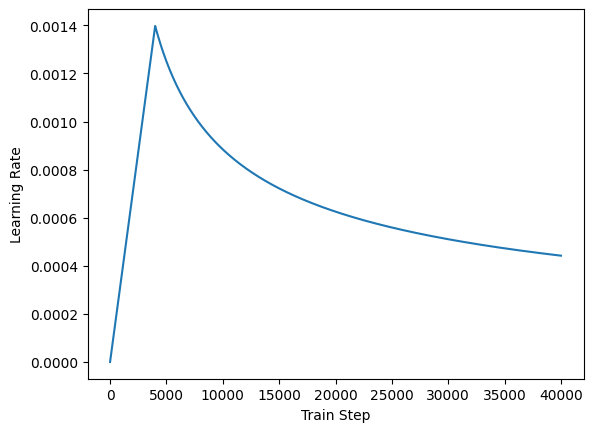

In [58]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

### 손실율 (Loss) 지표 설정

타겟 시퀀스는 패딩되므로 Loss를 계산할 때 패딩 마스크를 적용하는 것이 중요합니다. 크로스-엔트로피 손실 함수 (`tf.keras.losses.SparseCategoricalCrossentropy`)를 사용합니다.

In [59]:
def masked_loss(label, pred):
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none'
    )
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    loss = tf.reduce_sum(loss) / tf.reduce_sum(mask)
    return loss


def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0
    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match) / tf.reduce_sum(mask)

### 모델 학습

모든 구성 요소가 준비되었습니다! `model.compile`을 통해 학습 절차를 설정하고 `model.fit`을 사용하여 학습을 시작합니다:

참고 : 이 과정은 이벤트 엔진에서 `c5.24xlarge` (CPU-Only) 혹은 SageMaker의 `ml.g4dn.16xlarge` (GPU) 에서 수행할 경우 2시간 남짓 소요되며, 보다 높은 사양의 SageMaker GPU 노트북 인스턴스를 사용할 경우 단축될 수 있습니다.

In [60]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [ ]:
transformer.fit(train_batches,
                epochs=20,
                validation_data=val_batches)

## 추론 실행

이제 번역을 수행하여 모델을 테스트 할 수 있습니다. 추론은 다음 순서로 수행됩니다:

 * 포르투갈 토크나이저(`tokenizers.pt`)를 사용하여 입력 문장을 인코딩합니다. 이것이 인코더에 입력됩니다.
 * 디코더 입력은 `[START]` 토큰으로 초기화됩니다.
 * 패딩 마스크와 Look-ahead 마스크를 계산합니다.
 * `decoder` 는 `encoder 출력`과 자체 출력 (셀프 어텐션))을 살펴봄으로써 예측값을 출력합니다.
 * 예측된 토큰을 디코더 입력에 연결하고 디코더로 다시 전달합니다.
 * 이런 방식으로 디코더는 이전 토큰을 기반으로 다음 토큰을 예측합니다. 

 참고 :이 모델은 효율적인 학습을 위해 출력에서 각 토큰에 대해 동시에 다음 토큰을 예측합니다. 이것은 추론 중에 반복되며 마지막 예측값만 사용됩니다. 마지막 예측값만 계산하도록 개선함으로써 추론을 더 효율적으로 수행할 수 있습니다 (`training=False`). 

 `tf.Module`을 상속하여 `Translator`클래스를 정의합니다:

In [134]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    # The input sentence is Portuguese, hence adding the `[START]` and `[END]` tokens.
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()

    encoder_input = sentence

    # As the output language is English, initialize the output with the
    # English `[START]` token.
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # The output shape is `(1, tokens)`.
    text = tokenizers.en.detokenize(output)[0]  # Shape: `()`.

    tokens = tokenizers.en.lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights

# # Reformatted.
# class Translator(tf.Module):
#     def __init__(self, tokenizers, transformer):
#         self.tokenizers = tokenizers
#         self.transformer = transformer

#     def __call__(self, sentence, max_length=MAX_TOKENS):
#         assert isinstance(sentence, tf.Tensor)
#         if len(sentence.shape) == 0:
#             sentence = sentence[tf.newaxis]

#         sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()
#         encoder_input = sentence

#         start_end = self.tokenizers.en.tokenize([''])[0]
#         start = start_end[0][tf.newaxis]
#         end = start_end[1][tf.newaxis]

#         output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
#         output_array = output_array.write(0, start)

#         for i in tf.range(max_length):
#             output = tf.transpose(output_array.stack())
#             predictions = self.transformer([encoder_input, output], training=False)
#             predictions = predictions[:, -1:, :]
#             predicted_id = tf.argmax(predictions, axis=-1)
#             output_array = output_array.write(i+1, predicted_id[0])

#             if predicted_id == end:
#                 break

#         output = tf.transpose(output_array.stack())
#         text = tokenizers.en.detokenize(output)[0]
#         tokens = tokenizers.en.lookup(output)[0]

#         self.transformer([encoder_input, output[:, :-1]], training=False)
#         attention_weights = self.transformer.decoder.last_attn_scores

#         return text, tokens, attention_weights

`Translator` 클래스의 인스턴스를 만들고 몇 번 시도해 봅니다.

In [138]:
translator = Translator(tokenizers, transformer)

In [139]:
def print_translation(sentence, tokens, ground_truth):
    print(f'{"Input:":15s}: {sentence}')
    print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
    print(f'{"Ground truth":15s}: {ground_truth}')

예제 1:

In [140]:
sentence = 'este é um problema que temos que resolver.'
ground_truth = 'this is a problem we have to solve .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

PositionalEmbedding call()
length = tf.shape(x)[1]:  tf.Tensor(11, shape=(), dtype=int32)
x = self.embedding(x) shape:  (1, 11, 128)
x *= (scalar)tf.math.sqrt(tf.cast(self.d_model, tf.float32)) shape:  (1, 11, 128)
self.pos_encoding shape (pre):  (2048, 128)
y = self.pos_encoding[tf.newaxis, :length, :] shape:  (1, 11, 128)
(아래에서 참고) 1차원=배치 사이즈, 2차원= 시퀀스 길이, 3차원, 임베딩 벡터 길이
x = x + self.pos_encoding[tf.newaxis, :length, :1]:  (1, 11, 128)
PositionalEmbedding call()
length = tf.shape(x)[1]:  tf.Tensor(1, shape=(), dtype=int32)
x = self.embedding(x) shape:  (1, 1, 128)
x *= (scalar)tf.math.sqrt(tf.cast(self.d_model, tf.float32)) shape:  (1, 1, 128)
self.pos_encoding shape (pre):  (2048, 128)
y = self.pos_encoding[tf.newaxis, :length, :] shape:  (1, 1, 128)
(아래에서 참고) 1차원=배치 사이즈, 2차원= 시퀀스 길이, 3차원, 임베딩 벡터 길이
x = x + self.pos_encoding[tf.newaxis, :length, :1]:  (1, 1, 128)
PositionalEmbedding call()
length = tf.shape(x)[1]:  tf.Tensor(11, shape=(), dtype=int32)
x = self.embedding(x) shape:  (

PositionalEmbedding call()
length = tf.shape(x)[1]:  tf.Tensor(2, shape=(), dtype=int32)
x = self.embedding(x) shape:  (1, 2, 128)
x *= (scalar)tf.math.sqrt(tf.cast(self.d_model, tf.float32)) shape:  (1, 2, 128)
self.pos_encoding shape (pre):  (2048, 128)
y = self.pos_encoding[tf.newaxis, :length, :] shape:  (1, 2, 128)
(아래에서 참고) 1차원=배치 사이즈, 2차원= 시퀀스 길이, 3차원, 임베딩 벡터 길이
x = x + self.pos_encoding[tf.newaxis, :length, :1]:  (1, 2, 128)
PositionalEmbedding call()
length = tf.shape(x)[1]:  tf.Tensor(11, shape=(), dtype=int32)
x = self.embedding(x) shape:  (1, 11, 128)
x *= (scalar)tf.math.sqrt(tf.cast(self.d_model, tf.float32)) shape:  (1, 11, 128)
self.pos_encoding shape (pre):  (2048, 128)
y = self.pos_encoding[tf.newaxis, :length, :] shape:  (1, 11, 128)
(아래에서 참고) 1차원=배치 사이즈, 2차원= 시퀀스 길이, 3차원, 임베딩 벡터 길이
x = x + self.pos_encoding[tf.newaxis, :length, :1]:  (1, 11, 128)
PositionalEmbedding call()
length = tf.shape(x)[1]:  tf.Tensor(3, shape=(), dtype=int32)
x = self.embedding(x) shape:  (1

예제 2:

In [123]:
sentence = 'os meus vizinhos ouviram sobre esta ideia.'
ground_truth = 'and my neighboring homes heard about this idea .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

PositionalEmbedding call()
length = tf.shape(x)[1]:  tf.Tensor(10, shape=(), dtype=int32)
x = self.embedding(x) shape:  (1, 10, 128)
x *= (scalar)tf.math.sqrt(tf.cast(self.d_model, tf.float32)) shape:  (1, 10, 128)
self.pos_encoding shape (pre):  (2048, 128)
y = self.pos_encoding[tf.newaxis, :length, :] shape:  (1, 10, 128)
(아래에서 참고) 1차원=배치 사이즈, 2차원= 시퀀스 길이, 3차원, 임베딩 벡터 길이
x = x + self.pos_encoding[tf.newaxis, :length, :1]:  (1, 10, 128)
PositionalEmbedding call()
length = tf.shape(x)[1]:  tf.Tensor(1, shape=(), dtype=int32)
x = self.embedding(x) shape:  (1, 1, 128)
x *= (scalar)tf.math.sqrt(tf.cast(self.d_model, tf.float32)) shape:  (1, 1, 128)
self.pos_encoding shape (pre):  (2048, 128)
y = self.pos_encoding[tf.newaxis, :length, :] shape:  (1, 1, 128)
(아래에서 참고) 1차원=배치 사이즈, 2차원= 시퀀스 길이, 3차원, 임베딩 벡터 길이
x = x + self.pos_encoding[tf.newaxis, :length, :1]:  (1, 1, 128)
PositionalEmbedding call()
length = tf.shape(x)[1]:  tf.Tensor(10, shape=(), dtype=int32)
x = self.embedding(x) shape:  (

예제 3:

In [124]:
sentence = 'vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.'
ground_truth = "so i'll just share with you some stories very quickly of some magical things that have happened."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

PositionalEmbedding call()
length = tf.shape(x)[1]:  tf.Tensor(20, shape=(), dtype=int32)
x = self.embedding(x) shape:  (1, 20, 128)
x *= (scalar)tf.math.sqrt(tf.cast(self.d_model, tf.float32)) shape:  (1, 20, 128)
self.pos_encoding shape (pre):  (2048, 128)
y = self.pos_encoding[tf.newaxis, :length, :] shape:  (1, 20, 128)
(아래에서 참고) 1차원=배치 사이즈, 2차원= 시퀀스 길이, 3차원, 임베딩 벡터 길이
x = x + self.pos_encoding[tf.newaxis, :length, :1]:  (1, 20, 128)
PositionalEmbedding call()
length = tf.shape(x)[1]:  tf.Tensor(1, shape=(), dtype=int32)
x = self.embedding(x) shape:  (1, 1, 128)
x *= (scalar)tf.math.sqrt(tf.cast(self.d_model, tf.float32)) shape:  (1, 1, 128)
self.pos_encoding shape (pre):  (2048, 128)
y = self.pos_encoding[tf.newaxis, :length, :] shape:  (1, 1, 128)
(아래에서 참고) 1차원=배치 사이즈, 2차원= 시퀀스 길이, 3차원, 임베딩 벡터 길이
x = x + self.pos_encoding[tf.newaxis, :length, :1]:  (1, 1, 128)
PositionalEmbedding call()
length = tf.shape(x)[1]:  tf.Tensor(20, shape=(), dtype=int32)
x = self.embedding(x) shape:  (

## 어텐션 플롯 생성하기

이전 섹션에서 만든 `Translator` 클래스는 모델의 내부 작업을 시각화하는 데 사용할 수있는 어텐션 히드맵을 반환합니다. 

예를 들어:

In [125]:
sentence = 'este é o primeiro livro que eu fiz.'
ground_truth = "this is the first book i've ever done."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

PositionalEmbedding call()
length = tf.shape(x)[1]:  tf.Tensor(11, shape=(), dtype=int32)
x = self.embedding(x) shape:  (1, 11, 128)
x *= (scalar)tf.math.sqrt(tf.cast(self.d_model, tf.float32)) shape:  (1, 11, 128)
self.pos_encoding shape (pre):  (2048, 128)
y = self.pos_encoding[tf.newaxis, :length, :] shape:  (1, 11, 128)
(아래에서 참고) 1차원=배치 사이즈, 2차원= 시퀀스 길이, 3차원, 임베딩 벡터 길이
x = x + self.pos_encoding[tf.newaxis, :length, :1]:  (1, 11, 128)
PositionalEmbedding call()
length = tf.shape(x)[1]:  tf.Tensor(1, shape=(), dtype=int32)
x = self.embedding(x) shape:  (1, 1, 128)
x *= (scalar)tf.math.sqrt(tf.cast(self.d_model, tf.float32)) shape:  (1, 1, 128)
self.pos_encoding shape (pre):  (2048, 128)
y = self.pos_encoding[tf.newaxis, :length, :] shape:  (1, 1, 128)
(아래에서 참고) 1차원=배치 사이즈, 2차원= 시퀀스 길이, 3차원, 임베딩 벡터 길이
x = x + self.pos_encoding[tf.newaxis, :length, :1]:  (1, 1, 128)
PositionalEmbedding call()
length = tf.shape(x)[1]:  tf.Tensor(11, shape=(), dtype=int32)
x = self.embedding(x) shape:  (

토큰이 생성될 때 어텐션을 Plotting하는 함수를 만듭니다.

In [126]:
def plot_attention_head(in_tokens, translated_tokens, attention):
    # The model didn't generate `<START>` in the output. Skip it.
    translated_tokens = translated_tokens[1:]

    ax = plt.gca()
    ax.matshow(attention)
    ax.set_xticks(range(len(in_tokens)))
    ax.set_yticks(range(len(translated_tokens)))

    labels = [label.decode('utf-8') for label in in_tokens.numpy()]
    ax.set_xticklabels(
        labels, rotation=90)

    labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
    ax.set_yticklabels(labels)

In [127]:
head = 0
# Shape: `(batch=1, num_heads, seq_len_q, seq_len_k)`.
attention_heads = tf.squeeze(attention_weights, 0)
attention = attention_heads[head]
attention.shape

TensorShape([128, 11])

아래는 입력 (포르투갈어) 토큰입니다:

In [128]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]
in_tokens

<tf.Tensor: shape=(11,), dtype=string, numpy=
array([b'[START]', b'este', b'e', b'o', b'primeiro', b'livro', b'que',
       b'eu', b'fiz', b'.', b'[END]'], dtype=object)>

그리고 아래는 출력 (영어 번역) 토큰입니다:

In [129]:
translated_tokens

<tf.Tensor: shape=(129,), dtype=string, numpy=
array([b'[START]', b'like', b'##cist', b'services', b'documented', b'you',
       b'plants', b'oxford', b'crossing', b'issues', b'bite', b'issues',
       b'revolutions', b'revolutions', b'revolutions', b'revolutions',
       b'aside', b'competitive', b'luck', b'crossing', b'biology',
       b'revolutions', b'revolutions', b'button', b'##iling', b'##iling',
       b'radical', b'##eric', b'face', b'dimensions', b'revolutions',
       b'##asis', b'ways', b'materials', b'revolutions', b'revolutions',
       b'revolutions', b'informed', b'measured', b'revolutions',
       b'revolutions', b'revolutions', b'revolutions', b'##eric', b'##$',
       b'##eric', b'voice', b'fire', b'##itive', b'religion', b'oxford',
       b'passenger', b'friendly', b'infrastructure', b'support',
       b'support', b'support', b'support', b'cars', b'media', b'laptop',
       b'enjoy', b'services', b'cars', b'services', b'reduce', b'observe',
       b'score', b'origin

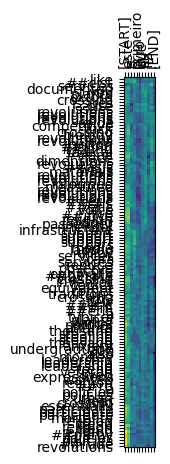

In [130]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [131]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
    in_tokens = tf.convert_to_tensor([sentence])
    in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
    in_tokens = tokenizers.pt.lookup(in_tokens)[0]

    fig = plt.figure(figsize=(16, 8))

    for h, head in enumerate(attention_heads):
        ax = fig.add_subplot(2, 4, h+1)

        plot_attention_head(in_tokens, translated_tokens, head)

        ax.set_xlabel(f'Head {h+1}')

    plt.tight_layout()
    plt.show()

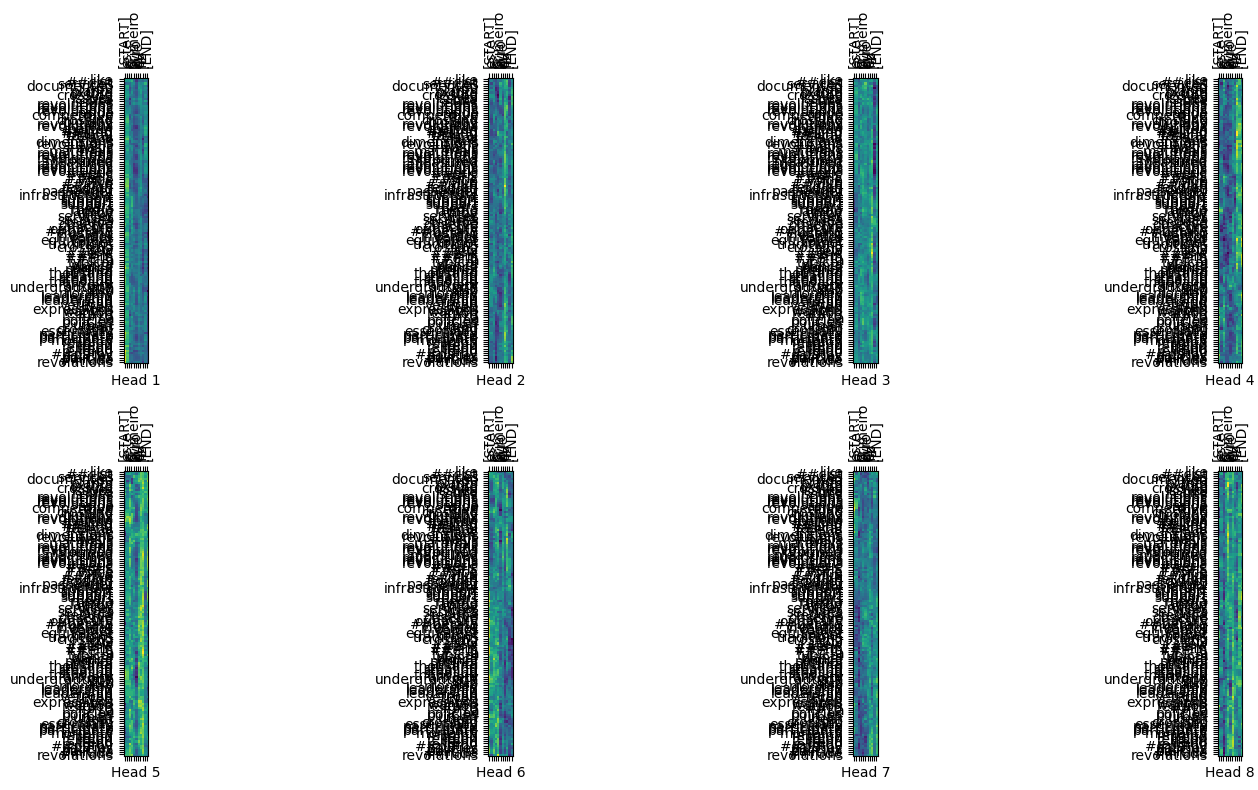

In [132]:
plot_attention_weights(sentence,
                       translated_tokens,
                       attention_weights[0])

이 모델은 익숙하지 않은 단어를 처리할 수 있습니다. ``triceratops'` 또는 `'encyclopédia'`는 입력 데이터 세트에 없지만 모델은 공유된 어휘 사전이 없이도 번역을 시도합니다. 예를 들어:

PositionalEmbedding call()
length = tf.shape(x)[1]:  tf.Tensor(19, shape=(), dtype=int32)
x = self.embedding(x) shape:  (1, 19, 128)
x *= (scalar)tf.math.sqrt(tf.cast(self.d_model, tf.float32)) shape:  (1, 19, 128)
self.pos_encoding shape (pre):  (2048, 128)
y = self.pos_encoding[tf.newaxis, :length, :] shape:  (1, 19, 128)
(아래에서 참고) 1차원=배치 사이즈, 2차원= 시퀀스 길이, 3차원, 임베딩 벡터 길이
x = x + self.pos_encoding[tf.newaxis, :length, :1]:  (1, 19, 128)
PositionalEmbedding call()
length = tf.shape(x)[1]:  tf.Tensor(1, shape=(), dtype=int32)
x = self.embedding(x) shape:  (1, 1, 128)
x *= (scalar)tf.math.sqrt(tf.cast(self.d_model, tf.float32)) shape:  (1, 1, 128)
self.pos_encoding shape (pre):  (2048, 128)
y = self.pos_encoding[tf.newaxis, :length, :] shape:  (1, 1, 128)
(아래에서 참고) 1차원=배치 사이즈, 2차원= 시퀀스 길이, 3차원, 임베딩 벡터 길이
x = x + self.pos_encoding[tf.newaxis, :length, :1]:  (1, 1, 128)
PositionalEmbedding call()
length = tf.shape(x)[1]:  tf.Tensor(19, shape=(), dtype=int32)
x = self.embedding(x) shape:  (

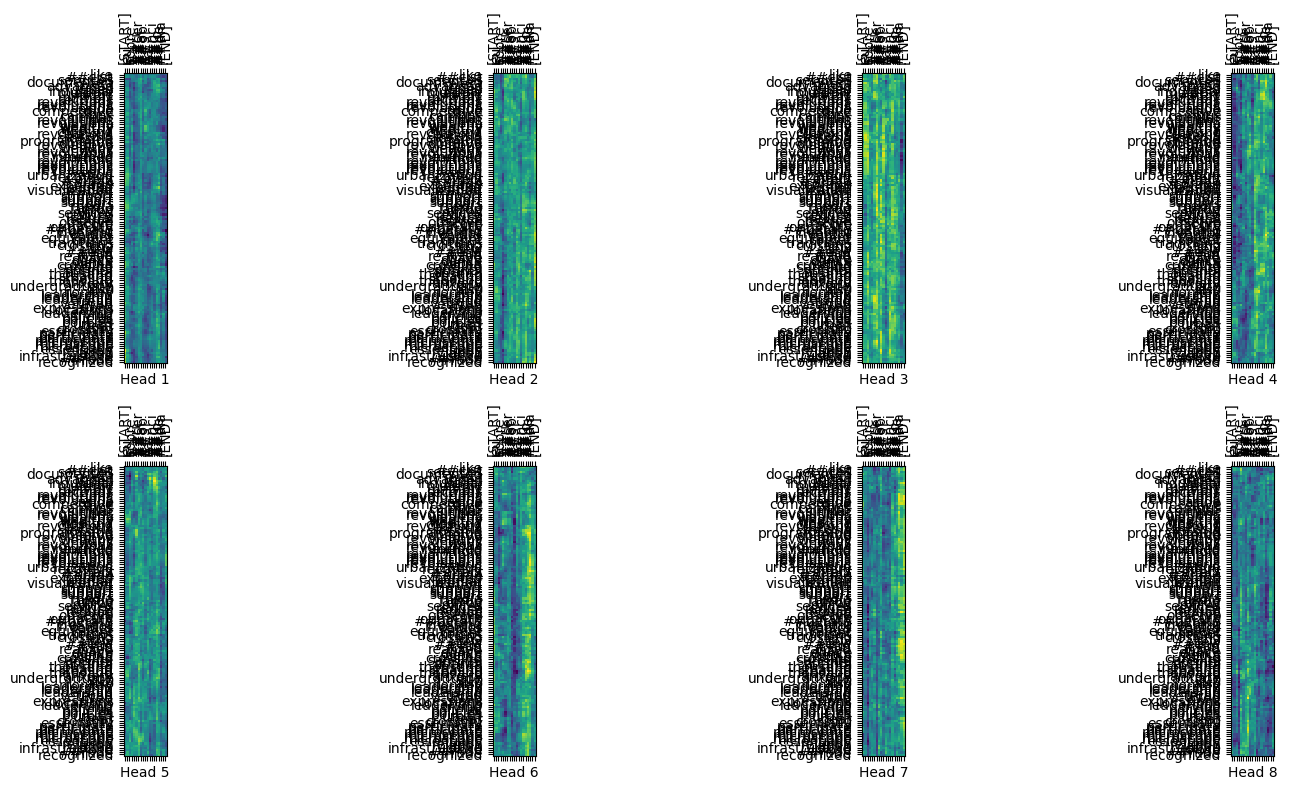

In [133]:
sentence = 'Eu li sobre triceratops na enciclopédia.'
ground_truth = 'I read about triceratops in the encyclopedia.'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

plot_attention_weights(sentence, translated_tokens, attention_weights[0])

## 모델 익스포트

모델을 테스트했으며 추론(번역)이 동작하는 것을 확인하였습니다. 이제 `tf.saved_model`으로 내보낼 수 있습니다. 탠서플로우의 SavedModel 형식의 모델 저장 및 로드에 대해 알아 보려면 [SavedModel 안내서](https://www.tensorflow.org/guide/saved_model)를 참조하십시요.

`tf.Module` 서브클래싱하여 `ExportTranslator`라는 클래스를 만들고 `tf.function` Decorator를 `__call__` 메서드에 부여합니다.

`@tf.function` 데코레이터는 Python 함수를 Tensorflow 그래프 함수로 변환하는 데 사용되며 Tensorflow의 그래프 모드에서 기능을 실행합니다. 이것은 이와 같이 많은 작은 텐서플로우 작업을 수행하는 기능에 대해 상당한 성능 향상을 제공 할 수 있습니다.

In [ ]:
class ExportTranslator(tf.Module):
    def __init__(self, translator):
        self.translator = translator

    @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
    def __call__(self, sentence):
        (result,
        tokens,
        attention_weights) = self.translator(sentence, max_length=MAX_TOKENS)

        return result

위에서 `tf.function`는 출력 문장만 반환됩니다. [non-strict execution](https://tensorflow.org/guide/intro_to_graphs) 기능 덕분에 불필요한 값은 계산되지 않습니다.

`ExportTranslator` 클래스로 `translator` 객체를 감쌉니다:

In [ ]:
translator = ExportTranslator(translator)

모델이 `tf.argmax`를 사용하여 예측을 해독하고 있기 때문에 예측은 Deterministic합니다. 또한 원래 모델과 `SavedModel`에서 다시 로드 된 모델은 동일한 예측을 제공해야 합니다.

In [ ]:
translator('este é o primeiro livro que eu fiz.').numpy()

In [ ]:
tf.saved_model.save(translator, export_dir='translator')

In [ ]:
reloaded = tf.saved_model.load('translator')

In [ ]:
reloaded('este é o primeiro livro que eu fiz.').numpy()

## 결론

이 튜토리얼에서 우리는 다음과 같은 것들 살펴보았습니다.

* 트랜스포머와 기계 학습에서의 중요성
* 어텐션, 셀프 어텐션 및 멀티 헤드 어텐션
* 임베딩을 통한 위치 인코딩
* 트랜스포머의 인코더 디코더 아키텍처
* 셀프 어텐션의 마이킹
* 텍스트를 번역해 주는 모델을 통해 모든 것을 통합

이 아키텍처의 단점은 다음과 같습니다.

- 시계열의 경우, 시간 단계의 출력은 입력 및 현재의 은닉 상태 대신 *전체 기록*을 통해 계산됩니다. 이 경우 효율이 저하될 수 있습니다.
- 입력에 텍스트나 이미지와 같은 임시적/공간적 관계가 있는 경우 일부 위치 인코딩을 추가하여야 하며, 그렇지 않을 경우 모델은 실질적으로 단어의 묶음만을 보게됩니다.

실제로 트랜스포머 모델을 구현한다면 다음과 같은 것들 수행할 필요가 있습니다.

* 트랜스포머를 학습시키기 위한 다양한 데이터세트
* "기본 트랜스포머" 혹은 "트랜스포머 XL"을 생성하고 하이퍼파라미터 설정
* [BERT](https://arxiv.org/abs/1810.04805)를 구현하기 위해 여기에 사용된 모델 활용
* Beam Search를 사용하여 보다 나은 예측값 얻기

다양한 트랜스포머 기반 모델이 있으며, 그 중 다수는 인코더 디코더, 인코더 전용 및 디코더 전용 아키텍처를 갖추고 2017 버전의 원래 트랜스포머의 성능을 향상시키고 있습니다.

이 모델 중 일부는 다음 연구 간행물에서 찾아볼 수 있습니다.

* ["Efficient Transformers: a survey"](https://arxiv.org/abs/2009.06732) (Tay et al., 2022)
* ["Formal algorithms for Transformers"](https://arxiv.org/abs/2207.09238) (Phuong and Hutter, 2022).
* [T5 ("Exploring the limits of transfer learning with a unified text-to-text Transformer")](https://arxiv.org/abs/1910.10683) (Raffel et al., 2019)

AWS가 지원하는 거대 언어 모델에 대해서는 아래 자료를 참고하십시요.
* [TODO]

Google의 모델에 댛서는 다음을 참고하세요.

* [PaLM](https://ai.googleblog.com/2022/04/pathways-language-model-palm-scaling-to.html).
* [LaMDA](https://ai.googleblog.com/2022/01/lamda-towards-safe-grounded-and-high.html)
* [MUM](https://blog.google/products/search/introducing-mum/)
* [Reformer](https://ai.googleblog.com/2020/01/reformer-efficient-transformer.html)
* [BERT](https://ai.googleblog.com/2018/11/open-sourcing-bert-state-of-art-pre.html)

자연 언어 처리 이외의 작업에 어텐션 기반 모델이 어떻게 적용되었는지 연구하는 데 관심이 있으시면 다음 리소스를 확인하십시오.

- Vision Transformer (ViT): [Transformers for image recognition at scale](https://ai.googleblog.com/2020/12/transformers-for-image-recognition-at.html)
- [Multi-task multitrack music transcription (MT3)](https://magenta.tensorflow.org/transcription-with-transformers) with a Transformer
- [Code generation with AlphaCode](https://www.deepmind.com/blog/competitive-programming-with-alphacode)
- [Reinforcement learning with multi-game decision Transformers](https://ai.googleblog.com/2022/07/training-generalist-agents-with-multi.html)
- [Protein structure prediction with AlphaFold](https://www.nature.com/articles/s41586-021-03819-2)
- [OptFormer: Towards universal hyperparameter optimization with Transformers](http://ai.googleblog.com/2022/08/optformer-towards-universal.html)
